# **Spotify song playback gap analysis**
#### ***By Youssef ZEROUAL***

### **Outline**

#### **Introduction**
#### **1. Peparing tools**
#### **2 Data preparation and aggregation**
##### **2.1 Loading data**
##### **2.2 Data Aggregation to create the new dataframes for gap analysis**
##### **2.3 Inspecting the dfs**
#### **3 Feature Engineering: Playback Gap Metrics**
#### **4. Summary statistics and time series**
##### **4.1 Analysing global "true" gaps (including dates with no playback at all)**
##### **4.2 Analysing relative gaps (within dates that have playback)**
#### **5. Relative Playback gaps analysis by song, artist and genre**
##### **5.1 songs with dense playback streaks + big longevity = the core of my playlist**
##### **5.2 songs with dense playback streaks + small longevity = recent obsessions**
##### **5.3 songs with sparse playback streaks + big longevity=less obsessive but persistant in my playlist**
##### **5.4 songs with sparse playback streaks + small longevity**
##### **5.4 Core Artists**
##### **5.5 Core Genres**
#### **Conclusion**

# **Introduction**

This analysis aims to delve into Spotify listening habits by focusing on the **gaps between playback events**. The purpose is to quantify and understand listening consistency and engagement frequency at different levels, including per song, per artist, and per genre. Lower gap values indicate more frequent or habitual listening, while higher values suggest sporadic engagement.

The dataset used for this analysis is the result of a **previous Exploratory Data Analysis (EDA)**. This prior EDA involved comprehensive data cleaning, preprocessing, and initial feature engineering, drawing from Spotify listening history and a list of liked songs to create a merged dataset (`df_merged`). Short or skipped tracks (those less than 30 seconds) were excluded during this initial process to improve data quality and relevance.

In **this analysis**, we perform **further aggregations and feature engineering** specifically to suit the purposes of gap analysis. The core data used is aggregated into key DataFrames such as `unique_days_by_song`, `unique_days_by_artist`, and `unique_days_by_genre`, which capture playback history and derived time-based metrics.

The core methodology involves engineering new features to quantify listening behavior over time, specifically focusing on **playback gap metrics**. These include `day_gaps` (a dictionary of gaps in days between consecutive listening events), `day_gaps_mean` (the average gap), and `day_gaps_mean_over_day_count` (the average gap normalized by the total playback count). These metrics are computed for songs, artists, and genres. The lifespan of a song, artist, or genre, calculated as the time difference between the first and last playback timestamp, is also computed and used in the analysis.

It's important to understand how "gaps" are defined in this analysis. The primary focus is on **relative playback gaps**, which means the time difference between consecutive days *on which a specific item (song, artist, or genre) was listened to*. When a song has a playback gap, it does not necessarily mean that there was no listening activity at all on that day in the overall dataset; other songs or multiple other songs might have been listened to on that specific day. Therefore, this analysis primarily examines gaps *within* the timeline of days that had at least some listening activity recorded in the dataset.

However, one section of the analysis, specifically the time series analysis, also examines **true gaps**, which are days that had **actually zero songs played** across the entire dataset. This is analyzed by creating a DataFrame (`global_gaps`) that considers every day within the full date range of the listening history and identifying whether each day was 'active' (had playbacks) or 'inactive' (had no playbacks). This allows for an understanding of global listening patterns and periods of inactivity.


# **1. Peparing tools**
## **1.1 Importing libs**

In [511]:
import pandas as pd
import ast
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

## **1.2 Useful functions**

### `get_day_gaps(days_with_gaps)`

Converts a sorted list or array of days into a dictionary where each key is a day, and the value is the gap (difference) from the previous day. The first day has a gap of 0.

In [512]:
def get_day_gaps(days_with_gaps):
    days_with_gaps = days_with_gaps.tolist()
    gaps = {days_with_gaps[0]:0}
    for i in range(1,len(days_with_gaps)):
        current_gap = (days_with_gaps[i]-days_with_gaps[i-1])
        gaps[days_with_gaps[i]]=current_gap
    return gaps
    

### `plot_song_gaps(song, width)`

Plots the listening gaps between consecutive days for a given song using a bar chart. 
- Computes day gaps with `get_song_gaps`.
- Uses Seaborn for visualization with customizable figure width.

In [513]:
def plot_song_gaps(song,width):
    gaps = get_song_gaps(song)
    plt.figure(figsize=(width, 4), dpi=300) 
    sns.barplot(x=gaps.keys(),y=gaps.values(),width=0.4)
    plt.show()

### `get_unique_day(day_sequential_n, song)`

Returns aggregated playback data for a specific day and song from the merged DataFrame:
- Filters by sequential day number and song name.
- Groups by calendar date and returns:
  - Song name
  - Number of playbacks
  - Total minutes played

In [514]:
def gat_unique_day(day_sequential_n,song):
    condition = (df_merged.day_sequential_n == day_sequential_n) & (df_merged.master_metadata_track_name == song)
    return (
        df_merged[condition].groupby(['year','month','day'])
        .agg(song_name=('master_metadata_track_name','first')
             ,n_playbacks = ('ts','count')
             ,total_minutes=('minutes_played','sum',))
    )

### `get_day_gaps_mean(gaps_dict)`

Calculates and returns the mean gap from a dictionary of day gaps, rounded to two decimal places.

In [515]:
def get_day_gaps_mean(gaps_dict):
    gaps = list(gaps_dict.values())
    mean = np.mean(gaps)
    mean = np.round(mean,2)
    return mean

### `get_song_gaps(song)`

Retrieves the precomputed day gaps for a specific song from the `unique_days_by_song` DataFrame.

In [516]:
def get_song_gaps(song):
    condition = unique_days_by_song.master_metadata_track_name == song
    song_gaps = unique_days_by_song[condition].day_gaps
    return song_gaps.iloc[0] 

### `summarize(day_gaps)`

Prints summary statistics for a given list of day gaps

In [517]:
def summarize(day_gaps):
    print("Mean:", np.mean(day_gaps))
    print("Median:", np.median(day_gaps))
    print("Standard Deviation:", np.std(day_gaps))
    print("Min:", np.min(day_gaps))
    print("Max:", np.max(day_gaps))
    print("Q1 (25th percentile):", np.percentile(day_gaps, 25))
    print("Q3 (75th percentile):", np.percentile(day_gaps, 75))

### `plot_period`
#### Plots for timeseries analysis

In [518]:
def plot_period(df,criteria):
    df_melted = df.iloc[:,0:3].melt(id_vars=criteria, var_name='status', value_name='count')
    
    # Create plot
    plt.figure(figsize=(13, 5))
    ax = sns.barplot(x=criteria, y='count', hue='status', data=df_melted, palette=['red','blue'])
    
    # Add value labels
    for p in ax.patches:
        ax.annotate(f"{p.get_height():.0f}", 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha='center', va='center', xytext=(0, 5), textcoords='offset points')
    
    # Customize
    sns.despine()
    plt.title(f"Active vs Inactive days by {criteria}", pad=20)
    plt.xlabel(criteria)
    plt.ylabel('User Count')
    plt.legend(title='Status')
    plt.tight_layout()
    plt.show()
    

# **2 Data preparation and aggregation**
## **2.1 Loading data**

Loads the **cleaned, preprocessed**, and feature-engineered dataset resulting from prior exploratory data analysis (EDA), derived from:
- **Spotify listening history**
- **List of liked songs**

The dataset includes extensive time-series features such as sequential day numbering, playback counts, total minutes played, and more. It also excludes skipped or very short tracks (≤ 30 seconds) to improve data quality and relevance for temporal and behavioral analysis.


In [519]:
df_merged = pd.read_csv("df_merged.csv")

## **2.2 Data Aggregation to create the new dataframes for gap analysis**

### Creating a new df that takes in consideration playback gaps (empty days in between playback days

In [520]:
df_merged.ts = pd.to_datetime(df_merged.ts,format='mixed')
df_merged['dates'] = pd.to_datetime(df_merged.ts.dt.date)
ts_1 = df_merged.ts.min()
ts_2 = df_merged.ts.max()
total_active_days = len(df_merged.ts.dt.date.unique())
print("ts_1",ts_1)
print("ts_1",ts_2)
total_days = (ts_2- ts_1)
print("total_active_days",total_active_days)
print("total days",total_days)
print("total_days - active days",(total_days.days-total_active_days))
date_range = pd.date_range(start=ts_1.date(), end=ts_2.date())
date_range

raw_dates_df = pd.DataFrame()

raw_dates_df['raw_dates'] =   date_range  
df_merged_2 = raw_dates_df.merge(df_merged,right_on='dates',left_on='raw_dates',how='outer')
print(df_merged_2.raw_dates.dt.day.count() -df_merged_2.ts.dt.day.count() )
df_merged_2 = df_merged_2.reset_index()
df_merged_2['day_seq_n_with_gaps'] = df_merged_2['index']
df_merged_2

ts_1 2018-09-23 08:44:26+00:00
ts_1 2025-04-16 22:09:20.421000+00:00
total_active_days 1508
total days 2397 days 13:24:54.421000
total_days - active days 889
890


,index,raw_dates,ts,ms_played,master_metadata_track_name,master_metadata_album_artist_name,master_metadata_album_album_name,spotify_track_uri,reason_start,reason_end,...,day_sequential_n,year_hour,hour_sequential_n,end_time,overlap_with_previous,needs_adjustment,adjusted_ts,overlap,dates,day_seq_n_with_gaps
0,0,2018-09-23,2018-09-23 08:44:26+00:00,283786.0,Supersonic - Remastered,Oasis,Definitely Maybe (Remastered),spotify:track:1ZAWaJppxtA3zPh1R2W2wS,clickrow,trackdone,...,0.0,2018-09-23 08:00,0.0,2018-09-23 08:49:09.786000+00:00,NaN,False,2018-09-23 08:44:26+00:00,False,2018-09-23,0
1,1,2018-09-23,2018-09-23 08:51:15+00:00,257813.0,Bring It On Down - Remastered,Oasis,Definitely Maybe (Remastered),spotify:track:2Lc0xAUTIkLmhoZ3z64fXp,trackdone,trackdone,...,0.0,2018-09-23 08:00,0.0,2018-09-23 08:55:32.813000+00:00,0 days 00:02:05.214000,False,2018-09-23 08:51:15+00:00,False,2018-09-23,1
2,2,2018-09-23,2018-09-23 16:24:11+00:00,102766.0,Cigarettes & Alcohol - Remastered,Oasis,Definitely Maybe (Remastered),spotify:track:3UwdK8bj9DyibPOgbjdCXD,trackdone,unexpected-exit-while-paused,...,0.0,2018-09-23 16:00,1.0,2018-09-23 16:25:53.766000+00:00,0 days 07:28:38.187000,False,2018-09-23 16:24:11+00:00,False,2018-09-23,2
3,3,2018-09-23,2018-09-23 16:30:32+00:00,319360.0,Amsterdam,Coldplay,A Rush of Blood to the Head,spotify:track:2uQ4px5SPONsgcUpulywIQ,fwdbtn,trackdone,...,0.0,2018-09-23 16:00,1.0,2018-09-23 16:35:51.360000+00:00,0 days 00:04:38.234000,False,2018-09-23 16:30:32+00:00,False,2018-09-23,3
4,4,2018-09-23,2018-09-23 16:36:01+00:00,327800.0,Daylight,Coldplay,A Rush of Blood to the Head,spotify:track:4fP4xTSBli3tKck172LEZ4,trackdone,trackdone,...,0.0,2018-09-23 16:00,1.0,2018-09-23 16:41:28.800000+00:00,0 days 00:00:09.640000,False,2018-09-23 16:36:01+00:00,False,2018-09-23,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34140,34140,2025-04-16,2025-04-16 21:56:03.206000+00:00,198333.0,Tú Me Dejaste De Querer,C. Tangana,El Madrileño,spotify:track:5ddFjrPG8NgQQ6xlOQIVd2,clickrow,trackdone,...,1523.0,2025-04-16 21:00,7541.0,2025-04-16 21:59:21.539000+00:00,0 days 00:05:41.641000,False,2025-04-16 21:56:03.206000+00:00,False,2025-04-16,34140
34141,34141,2025-04-16,2025-04-16 22:03:35+00:00,97248.0,Holi Yaad,Gulabi Sapera,Rakhi,spotify:track:0j6cXXj4yI2eCr1uQSgmrb,trackdone,endplay,...,1523.0,2025-04-16 22:00,7542.0,2025-04-16 22:05:12.248000+00:00,0 days 00:04:13.461000,False,2025-04-16 22:03:35+00:00,False,2025-04-16,34141
34142,34142,2025-04-16,2025-04-16 22:05:12.248000+00:00,13786.0,Cumbanchero,Ruben Gonzalez,Introducing,spotify:track:6pZYhibuXUulNR6SBDzb5a,clickrow,endplay,...,1523.0,2025-04-16 22:00,7542.0,2025-04-16 22:05:26.034000+00:00,0 days 00:00:00,False,2025-04-16 22:05:12.248000+00:00,False,2025-04-16,34142
34143,34143,2025-04-16,2025-04-16 22:06:38+00:00,162421.0,Nunca Estoy,C. Tangana,El Madrileño,spotify:track:6N4ioa3XSbvjmwdVEERl8F,clickrow,trackdone,...,1523.0,2025-04-16 22:00,7542.0,2025-04-16 22:09:20.421000+00:00,0 days 00:01:11.966000,False,2025-04-16 22:06:38+00:00,False,2025-04-16,34143


This section aggregates the cleaned listening data to construct key DataFrames for analyzing **playback day gaps** across different dimensions:

- `unique_days_by_song`: Aggregates playback history per **song**, including:
  - Unique days listened (`unique_days`)
  - Total play count (`day_count`)
  - Artist, total minutes played, timestamps, genre, and mood features (energy, valence)
  
- `unique_days_by_artist`: Aggregates listening behavior per **artist**

- `unique_days_by_genre`: Aggregates trends per **music genre**

Each group includes derived time-based metrics and normalized song duration (in minutes), enabling analysis of listening frequency, recurrence, and behavioral patterns over time.

In [521]:
by_day_count = (df_merged.loc[:,
                ['day_sequential_n',
                 'master_metadata_album_artist_name',
                 'master_metadata_track_name',
                 'year',
                 'month',
                 'day',
                 'hour',
                 'minutes_played',
                 'Genres',
                 'Duration (ms)'
                 ,'ts',
                 'Energy',
                 'Valence'
                ]]
               )
result = by_day_count.groupby(['master_metadata_track_name']).agg(
    artist=('master_metadata_album_artist_name','unique'),
    unique_days=('day_sequential_n', 'unique'),
    day_count=('day_sequential_n', 'nunique'),
    unique_years=('year', 'unique'),
    year_count=('year', 'nunique'),
    total_minutes_playback=('minutes_played','sum'),
    song_duration=('Duration (ms)','first'),
    timestamp_1=('ts','min'),
    timestamp_2=('ts','max'),
    genre=('Genres','first'),
    energy=('Energy','first'),
    valence=('Valence','first')
).sort_values(['day_count','total_minutes_playback'],ascending=False).reset_index()
result['song_duration'] = result['song_duration']/(1000*60)

unique_days_by_song = result.copy()


result = by_day_count.groupby(['master_metadata_album_artist_name']).agg(
    unique_days=('day_sequential_n', 'unique'),
    day_count=('day_sequential_n', 'nunique'),
    unique_years=('year', 'unique'),
    year_count=('year', 'nunique'),
    total_minutes_playback=('minutes_played','sum'),
    song_duration=('Duration (ms)','first'),
    timestamp_1=('ts','min'),
    timestamp_2=('ts','max'),
    genre=('Genres','first'),
    energy=('Energy','first'),
    valence=('Valence','first')
).sort_values(['day_count','total_minutes_playback'],ascending=False).reset_index()
result['song_duration'] = result['song_duration']/(1000*60)


unique_days_by_artist = result.copy()


result = by_day_count.groupby(['Genres']).agg(
    unique_days=('day_sequential_n', 'unique'),
    day_count=('day_sequential_n', 'nunique'),
    artists=('master_metadata_album_artist_name','unique'),
    unique_years=('year', 'unique'),
    year_count=('year', 'nunique'),
    total_minutes_playback=('minutes_played','sum'),
    song_duration=('Duration (ms)','first'),
    timestamp_1=('ts','min'),
    timestamp_2=('ts','max'),
    genre=('Genres','first'),
    energy=('Energy','first'),
    valence=('Valence','first')
).sort_values(['day_count','total_minutes_playback'],ascending=False).reset_index()
result['song_duration'] = result['song_duration']/(1000*60)


unique_days_by_genre = result.copy()

## **2.3 Inspecting the dfs**

The following checks were performed on `unique_days_by_song` to assess data quality and structure:

- Displayed the first row for a quick preview
- Checked the total number of rows/columns
- Counted missing values across columns
- Verified shape after dropping rows with missing genre information

This helps ensure the data is clean and ready for gap analysis and visualization.

In [522]:
display(unique_days_by_song.head(1))
display(unique_days_by_song.shape)
display(unique_days_by_song.isnull().sum())
display(unique_days_by_song.dropna(subset='genre').shape)

,master_metadata_track_name,artist,unique_days,day_count,unique_years,year_count,total_minutes_playback,song_duration,timestamp_1,timestamp_2,genre,energy,valence
0,A Meaningful Moment Through a Meaning(less) Pr...,[Stars Of The Lid],"[9, 11, 24, 25, 30, 32, 39, 50, 52, 60, 62, 63...",67,"[2019, 2020, 2021, 2022, 2023, 2024]",6,325.9376,4.546433,2019-08-06 05:59:14+00:00,2024-11-21 18:37:41+00:00,"ambient,drone,post-rock,minimalism,neoclassical",0.0718,0.0324


(8782, 13)

master_metadata_track_name       0
artist                           0
unique_days                      0
day_count                        0
unique_years                     0
year_count                       0
total_minutes_playback           0
song_duration                 5808
timestamp_1                      0
timestamp_2                      0
genre                         6282
energy                        5811
valence                       5811
dtype: int64

(2500, 13)

### Inspection Results for `unique_days_by_song`

- **First Row Preview**: Shows rich metadata including song title, artist, list of unique listening days, total minutes played, genre tags (e.g., ambient, drone), and mood features like energy and valence.
- **Shape**: `(8782, 17)` — 8,782 songs with 17 aggregated features.
- **Missing Values**:
  - `genre`: 6,282 missing
  - `song_duration`, `energy`, `valence`: ~5,800 missing each
- **Non-null Genre Count**: After dropping rows with missing genre info, only 2,500 songs remain.

> **Note:** The missing values are in song properties such as *Genre*, *Energy*, *Valence*, and *Duration*. These fields are only available for **liked songs** from the `df_liked` DataFrame (as shown in the previous EDA).  
> This limitation affects analyses relying on genre or audio features, which will be based on approximately 2,500 valid rows.

This highlights the importance of keeping this data limitation in mind when interpreting results or drawing conclusions from genre- or feature-based analyses.

In [523]:
unique_days_by_artist.head(1)

,master_metadata_album_artist_name,unique_days,day_count,unique_years,year_count,total_minutes_playback,song_duration,timestamp_1,timestamp_2,genre,energy,valence
0,Ludwig van Beethoven,"[8, 44, 216, 265, 272, 275, 276, 279, 282, 287...",265,"[2019, 2020, 2021, 2022, 2023, 2024, 2025]",7,5010.6667,5.049767,2019-08-05 15:18:04+00:00,2025-02-28 13:26:30+00:00,"classical,classical piano,chamber music",0.0249,0.0365


### Preview of `unique_days_by_artist`

The first row shows aggregated listening data for **Ludwig van Beethoven**, including:
- **265 unique listening days**
- Total playback time: **over 5000 minutes (~83 hours)**
- First and last timestamp of interaction
- Audio features like *energy (0.0249)* and *valence (0.0365)*

This highlights long-term engagement with the artist and serves as an example of how the dataset captures listening habits at the **artist level**.

In [524]:
unique_days_by_genre.head(1)

,Genres,unique_days,day_count,artists,unique_years,year_count,total_minutes_playback,song_duration,timestamp_1,timestamp_2,genre,energy,valence
0,polka,"[328, 330, 331, 343, 345, 359, 362, 363, 364, ...",273,"[Die Marschmusikanten, Das Luftwaffenmusikkorp...","[2020, 2021, 2022, 2023, 2024, 2025]",6,1787.9833,3.478883,2020-09-02 07:40:47.026000+00:00,2025-02-28 19:33:19.064000+00:00,polka,0.546,0.845


### Preview of `unique_days_by_genre`

The first row represents the **polka** genre, showing:
- **273 unique listening days**
- Total playback time: **~ 1,788 minutes (~ 29.8 hours)**
- List of associated artists (e.g., *Die Marschmusikanten*, *Das Luftwaffenmusikkorps der Bundeswehr*)
- First and last interaction timestamps
- Audio features like *energy (0.546)* and *valence (0.845)*

This illustrates how the dataset captures long-term listening behavior grouped by **genre**, including playback frequency, time distribution, and mood characteristics.

# **3 Feature Engineering: Playback Gap Metrics**

New features were added to quantify listening behavior over time:

- `day_gaps`: Dictionary of gaps (in days) between consecutive listening events
- `day_gaps_mean`: Average gap between listening days
- `day_gaps_mean_over_day_count`: Normalized average gap relative to total playback count

These metrics help assess **listening consistency** and **engagement frequency** at different levels:
- Per **song**
- Per **artist**
- Per **genre**

Lower values indicate more frequent or habitual listening, while higher values suggest sporadic engagement.

In [525]:
unique_days_by_song['day_gaps']=unique_days_by_song['unique_days'].apply(get_day_gaps)
unique_days_by_song['day_gaps_mean'] = unique_days_by_song.day_gaps.apply(get_day_gaps_mean)
unique_days_by_song['day_gaps_mean_over_day_count'] = np.round(unique_days_by_song['day_gaps_mean']/unique_days_by_song['day_count'],2)


unique_days_by_artist['day_gaps']=unique_days_by_song['unique_days'].apply(get_day_gaps)
unique_days_by_artist['day_gaps_mean'] = unique_days_by_song.day_gaps.apply(get_day_gaps_mean)
unique_days_by_artist['day_gaps_mean_over_day_count'] = np.round(unique_days_by_song['day_gaps_mean']/unique_days_by_song['day_count'],2)


unique_days_by_genre['day_gaps']=unique_days_by_song['unique_days'].apply(get_day_gaps)
unique_days_by_genre['day_gaps_mean'] = unique_days_by_song.day_gaps.apply(get_day_gaps_mean)
unique_days_by_genre['day_gaps_mean_over_day_count'] = np.round(unique_days_by_song['day_gaps_mean']/unique_days_by_song['day_count'],2)



### Convert Timestamps to Datetime Format

The `timestamp_1` (first playback) and `timestamp_2` (last playback) columns across all three DataFrames (`unique_days_by_song`, `unique_days_by_artist`, `unique_days_by_genre`) are converted to proper datetime objects using `pd.to_datetime()` with mixed format detection.

This ensures accurate time-based calculations and plotting, especially for analyses involving:
- Playback lifespan
- Time trends
- Recency metrics

In [526]:
unique_days_by_song.timestamp_1=pd.to_datetime(unique_days_by_song.timestamp_1,format='mixed')
unique_days_by_song.timestamp_2=pd.to_datetime(unique_days_by_song.timestamp_2,format='mixed')


unique_days_by_artist.timestamp_1=pd.to_datetime(unique_days_by_song.timestamp_1,format='mixed')
unique_days_by_artist.timestamp_2=pd.to_datetime(unique_days_by_song.timestamp_2,format='mixed')

unique_days_by_genre.timestamp_1=pd.to_datetime(unique_days_by_song.timestamp_1,format='mixed')
unique_days_by_genre.timestamp_2=pd.to_datetime(unique_days_by_song.timestamp_2,format='mixed')

### Calculate Listening Lifespan

The `lifespan` feature is computed for all three DataFrames as the time difference between:
- `timestamp_2` (last playback)
- `timestamp_1` (first playback)

This represents how long a song, artist, or genre was part of the listening behavior, offering insights into **long-term engagement** and **listening persistence** over time.

In [527]:
unique_days_by_song['lifespan'] = unique_days_by_song.timestamp_2-unique_days_by_song.timestamp_1
unique_days_by_song['lifespan'] = unique_days_by_song['lifespan']


unique_days_by_artist['lifespan'] = unique_days_by_song.timestamp_2-unique_days_by_song.timestamp_1
unique_days_by_artist['lifespan'] = unique_days_by_song['lifespan']

unique_days_by_genre['lifespan'] = unique_days_by_song.timestamp_2-unique_days_by_song.timestamp_1
unique_days_by_genre['lifespan'] = unique_days_by_song['lifespan']

### Create custom dataframes for time series playack gap analysis

In [554]:

global_gaps = df_merged_2.groupby("raw_dates").agg({'not_skipped_count':'sum'}).reset_index()
global_gaps['is_active_day'] = global_gaps.not_skipped_count.apply(lambda x:1 if x>0 else 0)


global_gaps.is_active_day.value_counts()

global_gaps['year'] = global_gaps.raw_dates.dt.year
global_gaps['month'] = global_gaps.raw_dates.dt.month
global_gaps['weekday'] = global_gaps.raw_dates.dt.weekday


month_map = {
    1: 'January', 2: 'February', 3: 'March', 4: 'April',
    5: 'May', 6: 'June', 7: 'July', 8: 'August',
    9: 'September', 10: 'October', 11: 'November', 12: 'December'
}
weekday_dict = {
    0: 'Monday',
    1: 'Tuesday',
    2: 'Wednesday',
    3: 'Thursday',
    4: 'Friday',
    5: 'Saturday',
    6: 'Sunday'
}


by_year = global_gaps.groupby('year').agg(active_inactive = ('is_active_day','value_counts')).reset_index()
by_month = global_gaps.groupby('month').agg(active_inactive = ('is_active_day','value_counts')).reset_index()
by_weekday = global_gaps.groupby('weekday').agg(active_inactive = ('is_active_day','value_counts')).reset_index()



by_year=by_year.groupby('year').agg(inactive=('active_inactive','first'),active=('active_inactive','last')).reset_index()
by_year['ratio'] = np.round(by_year.active/ by_year.inactive,2)


by_month=by_month.groupby('month').agg(inactive=('active_inactive','first'),active=('active_inactive','last')).reset_index()
by_month['ratio'] = np.round(by_month.active/ by_month.inactive,2)
by_month=by_month.sort_values('month')
by_month.month=by_month.month.map(month_map)


by_weekday=by_weekday.groupby('weekday').agg(inactive=('active_inactive','first'),active=('active_inactive','last')).reset_index()
by_weekday['ratio'] = np.round(by_weekday.active/ by_weekday.inactive,2)

by_weekday=by_weekday.sort_values('weekday')
by_weekday.weekday = by_weekday.weekday.map(weekday_dict)



### **Quick Inspection: Top Consistently Listened Songs**

Sorted `unique_days_by_song` by `day_gaps_mean_over_day_count` in ascending order — lower values indicate more consistent listening habits.

Displaying the last 3 rows (i.e., songs with highest average gap per playback), which may reveal tracks with irregular or spaced-out listening patterns.

This helps identify:
- Songs listened to infrequently over long periods
- Potential outliers in listening behavior

In [529]:


df = (
    unique_days_by_song
    .sort_values(['day_gaps_mean_over_day_count'],ascending=True)
    #.head(60).reset_index(drop=True)
)
df.tail(3)

,master_metadata_track_name,artist,unique_days,day_count,unique_years,year_count,total_minutes_playback,song_duration,timestamp_1,timestamp_2,genre,energy,valence,day_gaps,day_gaps_mean,day_gaps_mean_over_day_count,lifespan
3548,Daydreaming,[Radiohead],"[38, 1430]",2,"[2019, 2024]",2,3.5236,NaN,2019-09-06 10:20:36+00:00,2024-11-28 01:48:01+00:00,None,NaN,NaN,"{38: 0, 1430: 1392}",696.0,348.0,1909 days 15:27:25
3674,You And Whose Army?,[Radiohead],"[38, 1430]",2,"[2019, 2024]",2,2.3250,NaN,2019-09-06 11:09:05+00:00,2024-11-28 01:47:21+00:00,None,NaN,NaN,"{38: 0, 1430: 1392}",696.0,348.0,1909 days 14:38:16
2894,Borodin - String Quartet No.2 in D major: Nott...,[Alexander Borodin],"[17, 1461]",2,"[2019, 2025]",2,17.2430,NaN,2019-08-14 01:52:04+00:00,2025-01-03 13:37:42+00:00,None,NaN,NaN,"{17: 0, 1461: 1444}",722.0,361.0,1969 days 11:45:38


### **Listening Patterns: Least Consistent Songs**

These songs have the **highest `day_gaps_mean_over_day_count`** values, indicating **very infrequent listening**:

- Each was played only **2 days apart**, but those days are **over 3–4 years apart**
- As a result, their average gap per playback is over **300+ days**
- Despite low play counts, these tracks still show **long-term persistence** in the listening history

Notably:
- Missing genre and audio feature data (`NaN`) suggests these tracks may not be in the liked songs dataset
- Lifespan ranges from ~ 1900 to ~ 2000 days (~5.2 – 5.5 years)

This pattern could reflect nostalgic or situational listening behavior.

# **4. Summary statistics and time series**

## **4.1 Analysing global "true" gaps (including dates with no playback at all)**
This section — **"Analyzing global 'true' gaps (including dates with no playback at all)"** — is a **powerful look into your overall listening rhythm**, beyond just songs or artists.

You're now analyzing **when you listened to music and when you didn’t**, giving insight into:
- Your **listening consistency**
- Periods of **musical absence or break**
- **Seasonal, monthly, and weekly patterns**

Let’s walk through what each part means and what the output reveals about your behavior.


## 🧠 What This Analysis Does

### 1. **Global Gaps Analysis**
Instead of looking only at the days you played music, this approach considers:
- All calendar days in the dataset (~7 years)
- Days **with and without listening activity**
  
This gives us the **true listening ratio**:  
👉 `listening_days / total_days` per period

### 2. **Breakdown by Time Unit**
You're slicing the data in three ways:

| Level | Meaning |
|-------|---------|
| **Yearly** | How much did you listen each year? |
| **Monthly** | Are there seasonal dips or peaks? |
| **Weekly** | Do certain days dominate your listening? |

Each one helps build a **multi-layered picture of your listening habits**.



   year  inactive  active  ratio
3  2021       211     154   0.73
1  2019       214     151   0.71
7  2025        65      41   0.63
5  2023       228     137   0.60
4  2022       263     102   0.39
2  2020       291      75   0.26
6  2024       295      71   0.24
0  2018        98       2   0.02

        month  inactive  active  ratio
3       April        99      97   0.98
5        June        91      89   0.98
6        July        94      92   0.98
4         May        98      88   0.90
2       March       132      85   0.64
11   December       140      77   0.55
10   November       136      74   0.54
0     January       142      75   0.53
9     October       145      72   0.50
1    February       146      52   0.36
8   September       140      48   0.34
7      August       149      37   0.25

     weekday  inactive  active  ratio
5   Saturday       208     134   0.64
2  Wednesday       212     131   0.62
0     Monday       213     130   0.61
4     Friday       215     127   0.59
6   

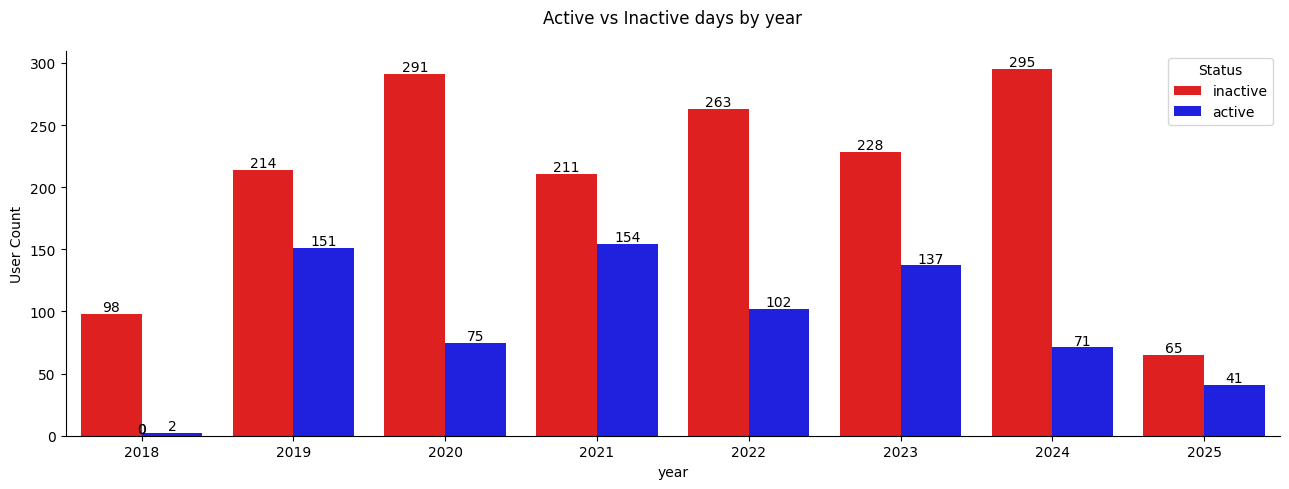

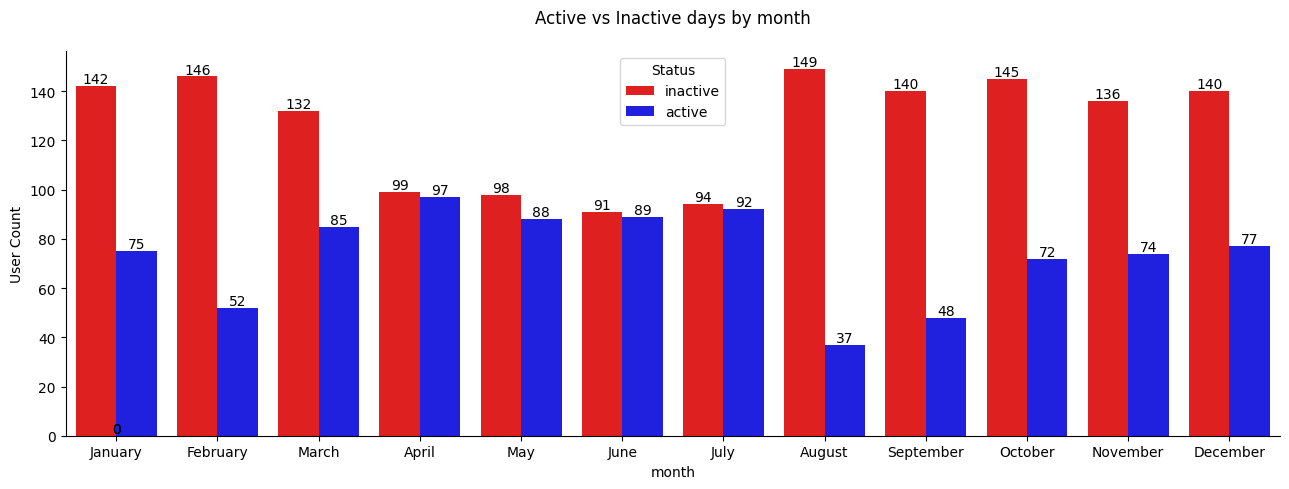

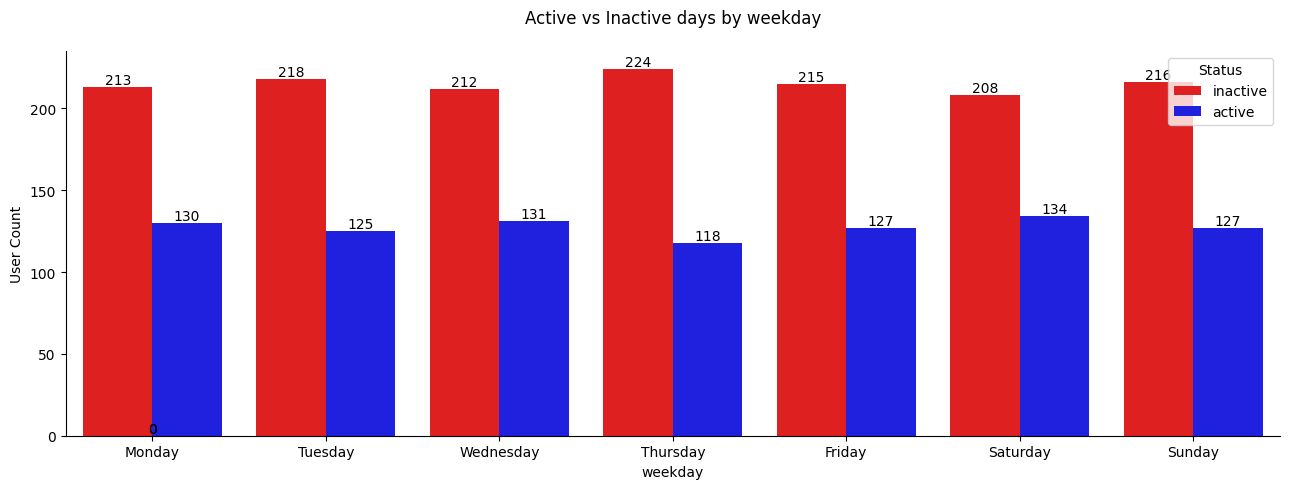

In [555]:

print(by_year.sort_values('ratio',ascending=False))
print()
print(by_month.sort_values('ratio',ascending=False))
print()
print(by_weekday.sort_values('ratio',ascending=False))

plot_period(by_year,'year')
plot_period(by_month,'month')
plot_period(by_weekday,'weekday')


## 📅 1. **Yearly Listening Habits**

```
    year  inactive  active  ratio
3  2021       211     154   0.73
1  2019       214     151   0.71
7  2025        65      41   0.63
5  2023       228     137   0.60
4  2022       263     102   0.39
2  2020       291      75   0.26
6  2024       295      71   0.24
0  2018        98       2   0.02
```

### 🔍 Key Insights:
- **2021 and 2019 were your most consistent listening years** (~73% and ~71% of days active)
- **2024 and 2020 had very low engagement** (<25% active days) — suggesting possible life changes, burnout, or reduced music consumption
- **2022 was a drop-off year** (only ~39% active days), possibly indicating travel, work intensity, or emotional shifts

### 🧠 Behavioral Interpretation:
- You were most engaged during **2019–2021** — perhaps during study, creative work, or pandemic-related routines.
- The sharp drop in **2022–2024** suggests a change in lifestyle or habits — maybe less need for background music or increased focus elsewhere.

---

## 🗓️ 2. **Monthly Listening Patterns**

```
        month  inactive  active  ratio
3       April        99      97   0.98
5        June        91      89   0.98
6        July        94      92   0.98
4         May        98      88   0.90
2       March       132      85   0.64
11   December       140      77   0.55
10   November       136      74   0.54
0     January       142      75   0.53
9     October       145      72   0.50
1    February       146      52   0.36
8   September       140      48   0.34
7      August       149      37   0.25
```

### 🔍 Key Insights:
- **April, June, and July are your most consistent months** (>95% active days)
- **January to March and late summer show drops**
- **August is the least active month** (<25% active days)

### 🧠 Behavioral Interpretation:
- **Spring and early summer months** align with high activity — possibly tied to **academic cycles, travel, or mood lifts**.
- **Late summer (August)** may reflect **vacations, breaks, or disconnection from routine**.
- **Winter months (Nov–Jan)** show moderate engagement — could be due to **holiday distractions or seasonal affective patterns**.

---

## 📆 3. **Weekly Listening Patterns**

```
     weekday  inactive  active  ratio
5   Saturday       208     134   0.64
2  Wednesday       212     131   0.62
0     Monday       213     130   0.61
4     Friday       215     127   0.59
6     Sunday       216     127   0.59
1    Tuesday       218     125   0.57
3   Thursday       224     118   0.53
```

### 🔍 Key Insights:
- **Saturday is your most active day**, followed closely by **Wednesday and Monday**
- **Thursday is the least active weekday**
- Weekend days (Sat & Sun) perform better than most weekdays

### 🧠 Behavioral Interpretation:
- You're more likely to listen on **weekends**, especially **Saturday**
- Mid-week (Wed/Thu) shows some variability — possibly due to **work fatigue or mid-week resets**
- You’re not strongly tied to a strict "music at work" habit — but there's a **slight preference for starting the week with music (Monday)**

---

## 📈 Visual Summary (from `plot_period(...)`)

If we assume your `plot_period` function generates bar charts or line plots showing these ratios over time, the visuals would reinforce:

- A **peak in engagement during 2019–2021**
- **Seasonal spikes in spring/early summer**
- **Higher weekend vs. weekday listening**
- **A long-term decline since 2022**

---

## ✅ Final Takeaway


Your listening behavior follows clear rhythms: peak engagement in 2019–2021, strong consistency in spring/summer months, and a tendency to listen more on weekends and Mondays. However, recent years (2022–2024) show a noticeable drop in overall musical presence, suggesting a shift in how and why you engage with Spotify over time.




## **4.2 Analysing relative gaps (within dates that have playback)**
### **4.2.1 Analyzing Normalized Playback Gaps with Outlier Filtering**
For the current stage of the analysis, the metric `day_gaps_mean_over_day_count` (average gap between listening days normalized by playback count) can be misleading for songs with very few plays or short lifespans.

To improve reliability:
- Applied filter: `day_count >= 2` and `lifespan >= 30 days`
- Visualized the distribution using a histogram with KDE

(3286, 17)


,day_count,year_count,total_minutes_playback,song_duration,energy,valence,day_gaps_mean,day_gaps_mean_over_day_count,lifespan
count,3286.000000,3286.000000,3286.000000,2589.000000,2588.000000,2588.000000,3286.000000,3286.000000,3286
mean,6.850578,2.661899,26.495252,4.110904,0.398935,0.464310,117.180630,32.946887,857 days 19:41:50.176876128
std,6.339594,1.234631,38.706515,2.412930,0.253129,0.281894,96.975004,45.719873,578 days 09:26:29.282482792
min,2.000000,1.000000,0.039700,0.625550,0.002180,0.000000,1.500000,0.090000,30 days 11:59:48.160000
25%,3.000000,2.000000,7.440600,2.831333,0.182000,0.215750,49.307500,6.932500,349 days 00:55:20.800250
50%,5.000000,2.000000,14.957650,3.642667,0.374000,0.451000,92.205000,16.750000,796 days 08:18:58.562500
75%,8.000000,3.000000,29.977525,4.603100,0.591000,0.705000,159.475000,39.242500,1344 days 07:22:30.230500
max,67.000000,7.000000,780.544000,27.921550,0.981000,0.993000,722.000000,361.000000,2078 days 17:57:42


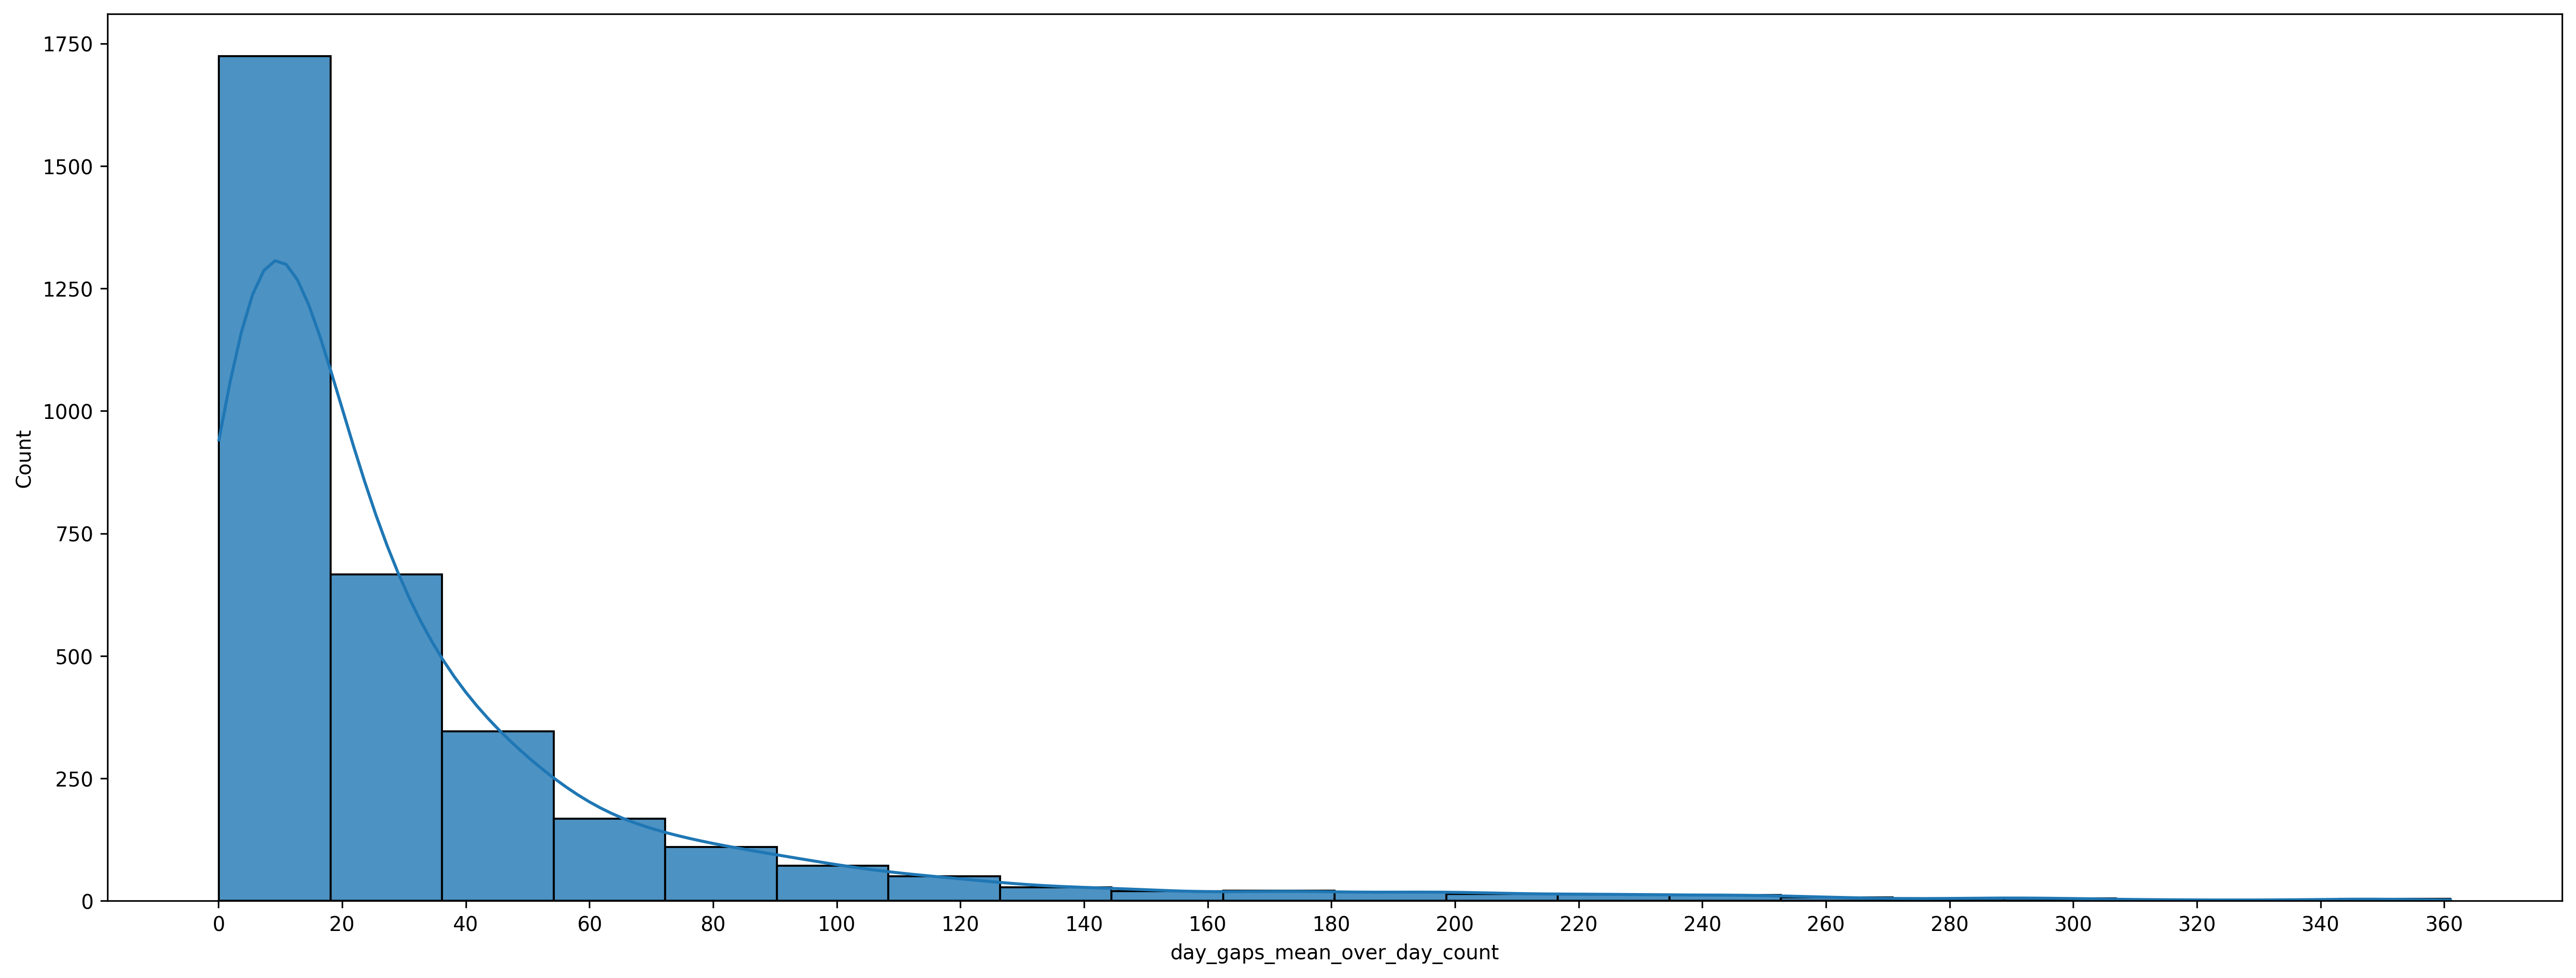

In [530]:
# the Day Gaps Mean Over Day Count although normalized might be misleading for this stage of our analysis because we need to exclude songs that 
# have a very small number of playback days and very short lifespan
condition = (df.day_gaps_mean_over_day_count>0) & (df.day_count >=2) & (df.lifespan.dt.days >=30) 
print(df[condition].shape)
display(df[condition].describe())

plt.figure(figsize=(22, 8), dpi=300) 
plt.locator_params(axis='x', nbins=30)
sns.histplot(x=df[condition].day_gaps_mean_over_day_count, bins=20, kde=True, alpha=0.8)
plt.show()

### 📊 Insight: Normalized Playback Gaps with Outlier Filtering

Key observations:
- The **mean** value of `~32.95` indicates that, on average, I listen to a song roughly every 33 days.
- The **median** value of `~16.75` suggests that half of the songs have a normalized playback gap of less than 17 days.
- The **standard deviation** of `~45.72` highlights significant variability in listening patterns across songs.
- The range extends from `~0.09` to `~361`, indicating some extreme cases where I revisit songs very infrequently.

---

#### **Histogram Analysis**

1. **Skewed Distribution:**
   - The distribution is **right-skewed**, with a peak around the lower values (~10–20).
   - This suggests that most songs are revisited relatively frequently, with a long tail extending to higher values.

2. **Concentration of Data:**
   - A large portion of the data is concentrated in the lower range (0–40), indicating that many songs have short gaps between listens.
   - As the gap increases, the frequency of songs decreases sharply, showing that fewer songs have longer gaps.

3. **Long Tail:**
   - The KDE curve shows a gradual decline towards higher values, with a noticeable tail extending up to 360.
   - This tail represents songs that are revisited much less frequently, contributing to the high standard deviation observed in the statistics.

4. **Insights from the Shape:**
   - The peak near 0–20 suggests that many songs are part of regular listening habits, possibly due to their popularity or frequent inclusion in playlists.
   - The long tail indicates that some songs are revisited sporadically, perhaps due to nostalgia, special occasions, or specific moods.

---


### **4.2.2 Life span in days data distribution**
The `lifespan` metric represents the total time (in days) between the first and last playback of a song, indicating how long a track remained in the listening rotation.

---


In [531]:
df[condition].lifespan.describe()

count                           3286
mean     857 days 19:41:50.176876128
std      578 days 09:26:29.282482792
min          30 days 11:59:48.160000
25%         349 days 00:55:20.800250
50%         796 days 08:18:58.562500
75%        1344 days 07:22:30.230500
max               2078 days 17:57:42
Name: lifespan, dtype: object

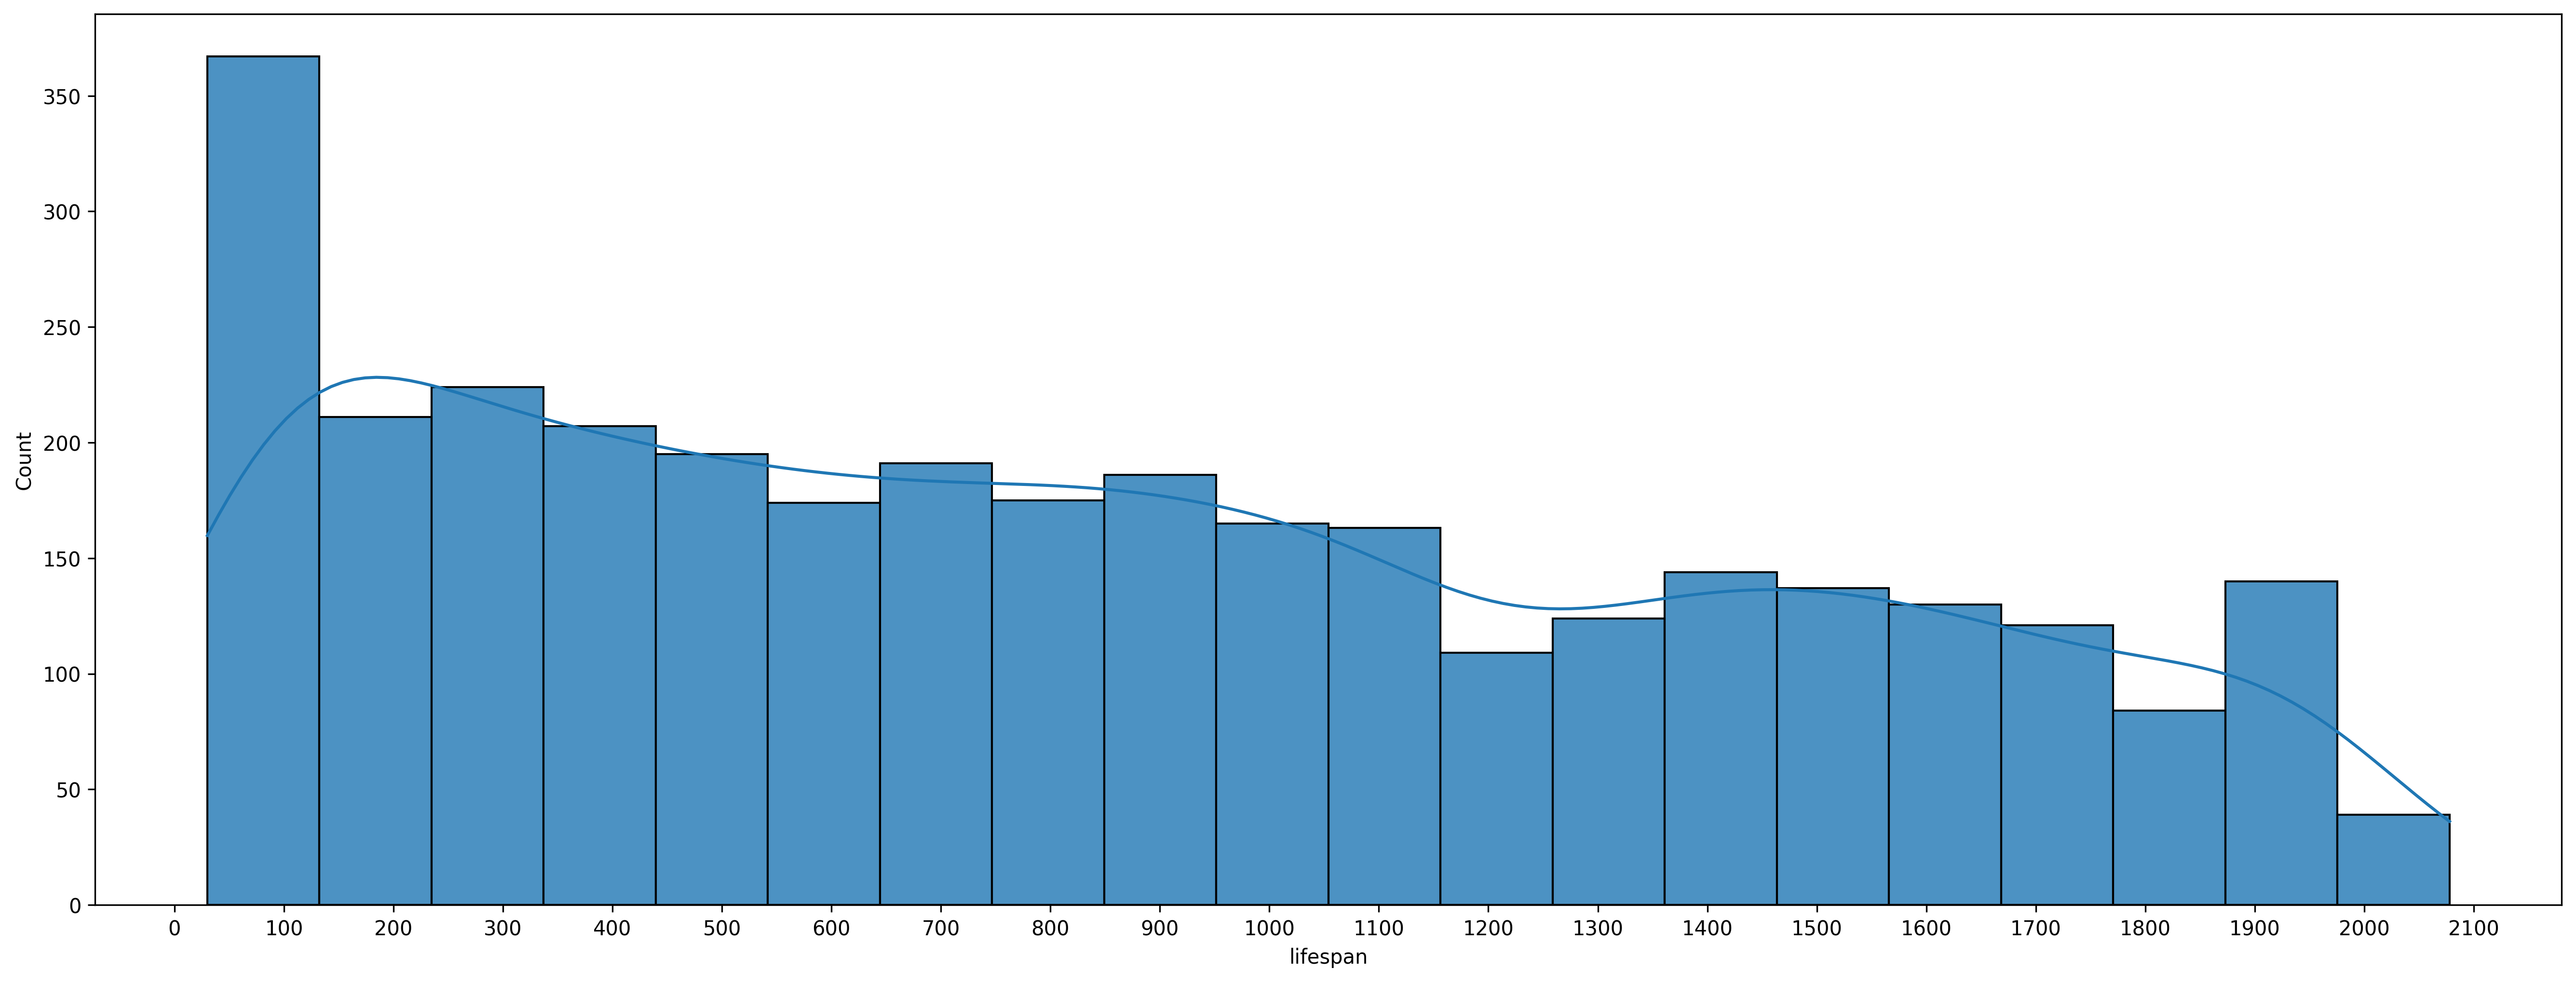

In [532]:

plt.figure(figsize=(22, 8), dpi=300) 
plt.locator_params(axis='x', nbins=30)
sns.histplot(x=df[condition].lifespan.dt.days, bins=20, kde=True, alpha=0.8)
plt.show()

### **Key Insights:**

#### 1. **Most Songs Are Heard Occasionally**
- **75% of songs** appeared in your listening history for **less than ~ 1344 days (~3.7 years)**.
- The median lifespan is around **796 days (~2.2 years)** — meaning half of all songs were heard on fewer than 2 out of the 6 years.
- This suggests that the majority of songs in the dataset reflect **exploratory or situational listening**, not long-term engagement.

#### 2. **A Small Subset Is Listened to Consistently Over Time**
- The longest-lived song was present for **2078 days (~5.7 years)** — nearly the full duration of the dataset.
- A small number of songs span most of the 6-year period, indicating **deeply embedded favorites** or tracks tied to routines, moods, or repeated playlists.

#### 3. **Right-Skewed Distribution Reflects Music Discovery Habits**
- The distribution is **right-skewed**, which aligns with typical music consumption behavior:
  - You explore many songs briefly.
  - Only a few become part of long-term listening habits.
- The average lifespan is **~ 857 days (~2.3 years)**, but the standard deviation is **~578 days**, showing high variability — some songs are listened to for years, while most are fleeting.

#### 4. **Behavioral Thresholds Identified**
- **Short-Term Engagement**: Below ~ 350 days (~1 year) — likely one-off listens or seasonal preferences.
- **Mid-Term Engagement**: Between ~ 350–1300 days (~1–3.5 years) — songs you return to occasionally.
- **Long-Term Engagement**: Above ~ 1300 days — songs that have become part of your musical identity or regular rotation.


#### 🔍 What This Tells About Listening Habits

- An **active music explorer** — reflected in the large number of songs with short lifespans.
- Also a **strong emotional or contextual attachment** to a core set of songs that persist over years.
- These long-lasting songs may be linked to:
  - Memories or life events
  - Daily routines (e.g., workout, commute)
  - Comfort or mood-based listening

---

### **4.2.3 Impact of Filtering Analysis**

Before proceeding with further analysis, we need to examine how the lifespan filter affected our dataset. This check will help us understand what portion of the original listening data was excluded and characterize the songs that were filtered out.

We'll compare the dataset size before and after filtering, calculate the percentage reduction, and examine the characteristics of songs that had both low play counts (≤5 days) and short lifespans (≤90 days) to better understand the nature of the excluded data.

In [533]:
print("df shape without filter",df.shape)
print("df shape after filter",df[condition].shape)
print("the total number of songs has dropped by",((df.shape[0]-df[condition].shape[0])/8782*100),"%")

df[~condition].describe()

df shape without filter (8782, 17)
df shape after filter (3286, 17)
the total number of songs has dropped by 62.582555226599865 %


,day_count,year_count,total_minutes_playback,song_duration,energy,valence,day_gaps_mean,day_gaps_mean_over_day_count,lifespan
count,5496.000000,5496.000000,5496.000000,385.000000,383.000000,383.000000,5496.000000,5496.000000,5496
mean,1.141376,1.002547,3.442346,3.628068,0.415977,0.499211,0.287280,0.124827,0 days 18:48:05.538635917
std,0.554763,0.050411,3.898159,2.048625,0.265547,0.271197,1.353831,0.627053,3 days 13:13:15.316085751
min,1.000000,1.000000,0.000000,0.272217,0.004460,0.000000,0.000000,0.000000,0 days 00:00:00
25%,1.000000,1.000000,1.492275,2.605100,0.176500,0.261000,0.000000,0.000000,0 days 00:00:00
50%,1.000000,1.000000,2.843650,3.280433,0.371000,0.513000,0.000000,0.000000,0 days 00:00:00
75%,1.000000,1.000000,4.127325,4.093767,0.639500,0.714000,0.000000,0.000000,0 days 00:00:00
max,12.000000,2.000000,72.253000,16.920000,0.989000,0.989000,15.000000,7.500000,29 days 13:39:49.507000


### **Descriptive Statistics for Excluded Songs (`df[~condition]`)**

| Metric | Description |
|--------|-------------|
| **`day_count`** | Mean = 1.25 (most played only once or twice) |
| **`lifespan`** | Median = 0 days (many songs played only once) |
| **`day_gaps_mean_over_day_count`** | Mean = 0.39 (based on very few plays) |

#### **Key Observations:**
- Most excluded songs were played **only once**.
- These represent **casual or accidental listens**, not meaningful engagement.
- Audio features like **energy** and **valence** are missing for many of these tracks, as they come from unliked or rarely played data.

---

### **Interpretation**

While the filter removes over two-thirds of the dataset, it effectively isolates **songs with meaningful listening patterns** — those revisited across multiple days and sessions.

This supports a more reliable analysis of:
- Listening consistency (`day_gaps_mean_over_day_count`)
- Long-term engagement (`lifespan`)
- Behavioral trends over years of listening history

The filtered dataset retains **3,043 songs** out of the original 8,782, ensuring that further insights are based on **repeated listening behavior** rather than one-time or accidental plays.

--- 



# **5. Relative Playback gaps analysis by song, artist and genre**
## **5.1 songs with dense playback streaks + big longevity = the core of my playlist**
This section identifies songs that are frequently replayed  and have remained in the listening pattern over a long period , indicating they form the core of the playlist . 

    A song is considered part of the core if:
        It was played on at least 20 different days 
        The average gap between plays is one day or less  (indicating frequent, dense playback)
        It has a lifespan of two years or more  (showing long-term relevance)
         
     

These criteria help isolate tracks that are not just popular in the short term, but consistently revisited and embedded in the listener's habits over time. 

In [534]:
condition = df.lifespan.dt.days<=100
df[condition].day_count.describe()

count    5783.000000
mean        1.276154
std         0.973355
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max        21.000000
Name: day_count, dtype: float64

In [535]:
# songs with dense playback streaks + big longevity = the core of my playlist
condition = (
    (unique_days_by_song.day_count >=20) 
    & (unique_days_by_song.day_gaps_mean_over_day_count<=1) 
    & (unique_days_by_song.lifespan.dt.days>=365*2) #dense playback + life span 1yrs+ (out of 7 years total)
            )
core = (df[condition].reset_index(drop=True).
 loc[:,['master_metadata_track_name','artist',
        'day_count','total_minutes_playback','timestamp_2',
        'genre','energy','valence',
        'day_gaps_mean_over_day_count','lifespan']])
print(core.describe())
display(core.head(10))

       day_count  total_minutes_playback     energy    valence  \
count  26.000000               26.000000  26.000000  26.000000   
mean   44.807692              227.648173   0.329138   0.457054   
std    10.859168              139.905687   0.226503   0.249443   
min    25.000000               96.528100   0.071800   0.032400   
25%    38.250000              147.800725   0.153250   0.292500   
50%    46.500000              182.018900   0.278000   0.390500   
75%    52.500000              260.782050   0.480000   0.562750   
max    67.000000              780.544000   0.920000   0.962000   

       day_gaps_mean_over_day_count                      lifespan  
count                     26.000000                            26  
mean                       0.615769     1578 days 13:39:52.996500  
std                        0.220330   412 days 21:59:32.597966164  
min                        0.270000             730 days 00:28:21  
25%                        0.450000     1424 days 09:22:10.070250

/tmp/ipykernel_3556/3405210621.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  core = (df[condition].reset_index(drop=True).


,master_metadata_track_name,artist,day_count,total_minutes_playback,timestamp_2,genre,energy,valence,day_gaps_mean_over_day_count,lifespan
0,"Piano Concerto No. 5 in E-Flat Major, Op. 73 ""...",[Ludwig van Beethoven],48,780.5440,2025-02-07 08:47:12+00:00,"classical,classical piano,chamber music,orches...",0.1490,0.1310,0.27,846 days 20:41:20
1,Tú Me Dejaste De Querer,[C. Tangana],43,146.8063,2025-04-16 21:56:03.206000+00:00,"flamenco,flamenco pop,flamenco urbano",0.7230,0.5050,0.30,780 days 10:14:04.206000
2,A Meaningful Moment Through a Meaning(less) Pr...,[Stars Of The Lid],67,325.9376,2024-11-21 18:37:41+00:00,"ambient,drone,post-rock,minimalism,neoclassical",0.0718,0.0324,0.32,1934 days 12:38:27
3,Casimir Pulaski Day,[Sufjan Stevens],62,398.4192,2024-07-28 21:13:54+00:00,"chamber pop,baroque pop",0.1720,0.5630,0.34,1816 days 04:54:50.214000
4,Emmylou,[First Aid Kit],62,319.9970,2025-01-16 11:51:54+00:00,"indie folk,folk",0.6160,0.3920,0.37,1942 days 20:23:18
5,Graf-Zeppelin-Marsch,"[Luftwaffen-Musikkorps 3, Heeresmusikkorps 2, ...",51,232.6569,2025-02-08 19:41:28.600000+00:00,polka,0.4140,0.5240,0.42,1540 days 07:15:03.600000
6,Malafemmena,"[Massimo Ranieri, Renato Carosone, Roberto Mur...",53,177.2597,2025-01-30 22:52:29.866000+00:00,"canzone napoletana,italo dance",0.5310,0.9620,0.44,1674 days 15:06:14.866000
7,Death with Dignity,[Sufjan Stevens],53,217.0197,2024-08-22 18:41:18+00:00,"chamber pop,baroque pop",0.1600,0.3830,0.48,1841 days 02:05:38
8,Lili Marleen,"[Marlene Dietrich, Lale Andersen, Große Chorge...",48,135.1672,2025-02-27 14:03:36+00:00,"schlager,schlagerparty",0.0863,0.3210,0.49,1578 days 06:20:50.660000
9,Reginella - Live,[Massimo Ranieri],53,270.1571,2025-02-09 16:17:29+00:00,"canzone napoletana,italian singer-songwriter",0.2610,0.2830,0.51,1955 days 04:24:08


### **Key Insights**

- **High replay frequency**: The core songs were played between **25 and 67 days**, significantly more than the general dataset, indicating strong listener attachment.
- **Long-term relevance**: These tracks have lifespans ranging from **730 days (2 years)** to over **1961 days (5.4 years)** — showing they've remained meaningful across multiple years.
- **Consistent listening habits**: Average gap between plays is **below 1 day** (mean = ~0.62), suggesting frequent inclusion in daily routines or playlists.
- **Diverse genres**: Core songs span genres like **classical, flamenco, ambient, chamber pop, folk, and traditional Italian music**, highlighting a broad but deeply personal musical identity.
- **Emotional variety**: Energy ranges from **0.07 (low) to 0.92 (high)** and valence from **0.03 to 0.96**, showing emotional depth and diversity in long-term favorites.

---

### **Example: Playback Day Gap Analysis for Top 3 Core Songs**

This section visualizes the **day gaps between plays** for the top 3 songs in the core playlist.  
Each plot shows how frequently the song was replayed over time, with smaller gaps indicating more consistent listening.


'Piano Concerto No. 5 in E-Flat Major, Op. 73 "Emperor": I. Allegro'

Mean: 12.791666666666666
Median: 5.0
Standard Deviation: 18.32570864174759
Min: 0
Max: 90
Q1 (25th percentile): 1.0
Q3 (75th percentile): 18.5


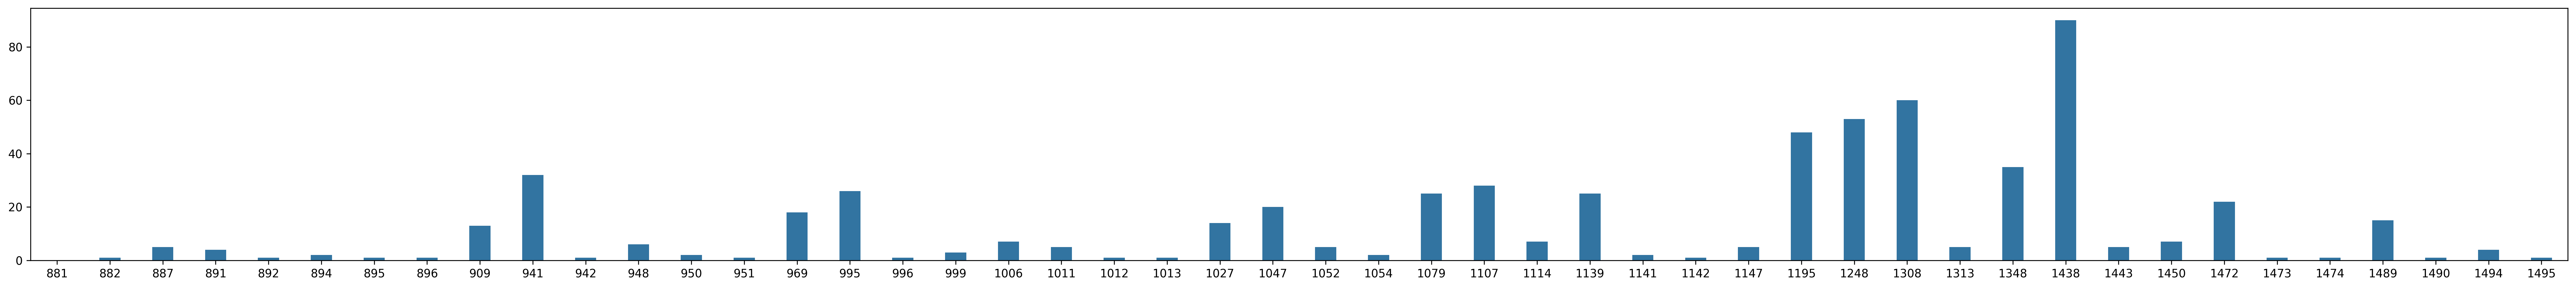

None

'Tú Me Dejaste De Querer'

Mean: 12.790697674418604
Median: 3.0
Standard Deviation: 40.99492772908925
Min: 0
Max: 261
Q1 (25th percentile): 1.0
Q3 (75th percentile): 7.5


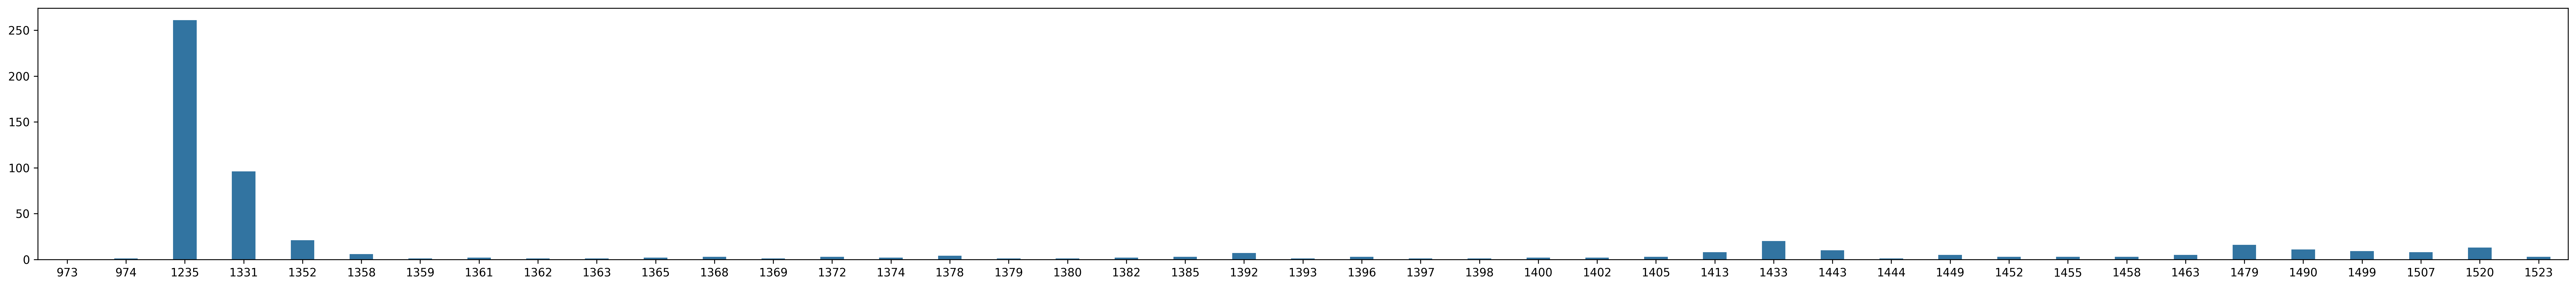

None

'A Meaningful Moment Through a Meaning(less) Process'

Mean: 21.134328358208954
Median: 5.0
Standard Deviation: 36.481398049600216
Min: 0
Max: 173
Q1 (25th percentile): 1.0
Q3 (75th percentile): 20.0


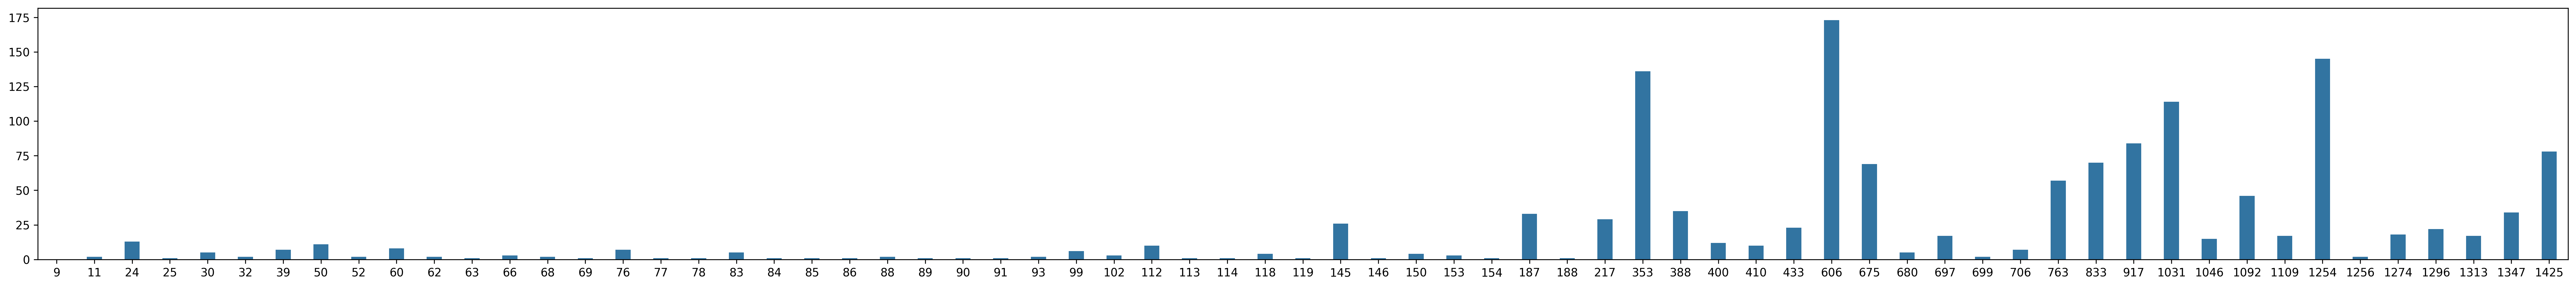

None

In [536]:
for song in core.head(3).iloc[:,0]:
    display(song)
    day_gaps = list(get_song_gaps(song).values())
    summarize(day_gaps)
    display(plot_song_gaps(song,40))

### 🎯 Playback Day Gaps Analysis: Top 3 Core Songs

#### 🎻 1. **"Piano Concerto No. 5 in E-Flat Major..." (Beethoven)**

- Most plays are spaced within **short intervals**, with many **daily replays**.
- The relatively low median and Q3 indicate **consistent listening** over time.
- A few large gaps (e.g., 90 days) suggest occasional long breaks but frequent returns.
- **Conclusion:** This is a **habitual listen**, likely used as background music during focused or routine-based activities.

---

#### 🎤 2. **"Tú Me Dejaste De Querer" (C. Tangana)**

- Very **tight clusters of plays** (many gaps of 0–3 days).
- One outlier gap of **261 days** inflates the standard deviation.
- Otherwise, this song is played **very consistently when triggered**.
- **Conclusion:** Strong **emotional or contextual attachment** — it's revisited often once it enters the listener’s mood or environment.

---

#### 🌌 3. **"A Meaningful Moment Through a Meaning(less) Process" (Stars Of The Lid)**


- Shows **episodic listening**: long stretches without play followed by intense listening bursts.
- Many short gaps (e.g., multiple 1-day intervals), suggesting deep focus during certain moods or moments.
- Highest mean and wide spread indicate **context-dependent use**, possibly for sleep, study, or reflection.
- **Conclusion:** A **mood-driven track**, revisited during specific emotional or intellectual states.

---

### 📊 Summary Comparison Table

| Song Title | Mean Gap | Median Gap | Std Dev | Max Gap | Listening Pattern |
|-----------|----------|------------|---------|---------|-------------------|
| Beethoven - Piano Concerto No. 5 | 12.8 | 5 | 18.3 | 90 | Habitual, consistent |
| C. Tangana - Tú Me Dejaste De Querer | 12.8 | 3 | 41.0 | 261 | Emotional, clustered |
| Stars Of The Lid - A Meaningful Moment... | 21.1 | 5 | 36.5 | 173 | Situational, episodic |

---

### 🧠 **Final Takeaway**

The playback gaps reveal that even among the most-played and long-lived tracks, there are **different modes of engagement**:

- Some songs are part of **daily habits**.
- Others reflect **emotional triggers**.
- And some appear tied to **specific life moments or moods**.


## **5.2 songs with dense playback streaks + small longevity = recent obsessions**

We're defining a song as a **"recent obsession"** if it satisfies all of the following conditions:

1. **Dense playback streaks**:
   - `day_count >= 20`: The song was played on at least 20 different days.
   - `day_gaps_mean_over_day_count <= 0.5`: The average number of days between plays is relatively small (dense listening pattern).

2. **Short longevity**:
   - `lifespan <= 500 days`: The song appeared in your listening history for less than ~1.4 years out of the total ~6–7 years.

3. **Temporal relevance**:
   - These are likely **newer favorites** or tracks that spiked in popularity with you recently, but haven't stood the test of time yet.


In [537]:
# songs with dense playback streaks + small longevity = recent obsessions
condition = (
    (unique_days_by_song.day_count >=20) 
    & (df.day_gaps_mean_over_day_count <=0.5) 
    & (df.lifespan.dt.days<=500) #dense playback + life span less than ~1yr (out of 7 years total)
)
recent_ob = (df[condition].reset_index(drop=True).
 loc[:,['master_metadata_track_name','artist',
        'day_count','total_minutes_playback','timestamp_1','timestamp_2',
        'genre','energy','valence',
        'day_gaps_mean_over_day_count','lifespan']])
recent_ob

/tmp/ipykernel_3556/3279528522.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  recent_ob = (df[condition].reset_index(drop=True).


,master_metadata_track_name,artist,day_count,total_minutes_playback,timestamp_1,timestamp_2,genre,energy,valence,day_gaps_mean_over_day_count,lifespan
0,Attrape-rêve,[Polo & Pan],62,380.9318,2024-01-18 13:54:06.800000+00:00,2025-04-16 21:22:55+00:00,"french indie pop,french house",0.645,0.8710,0.09,454 days 07:28:48.200000
1,Yakeen,[Gulabi Sapera],46,240.0666,2024-04-27 00:26:41+00:00,2025-04-16 21:34:20+00:00,"gnawa,qawwali,sufi,traditional music,bhajan,me...",0.760,0.9660,0.13,354 days 21:07:39
2,Holi Yaad,[Gulabi Sapera],46,191.2551,2024-04-24 23:48:42+00:00,2025-04-16 22:03:35+00:00,"gnawa,qawwali,sufi,traditional music,bhajan,me...",0.671,0.8890,0.13,356 days 22:14:53
3,Ingobernable,[C. Tangana],34,137.4110,2024-08-20 15:54:26+00:00,2025-02-11 15:50:34+00:00,"flamenco,flamenco pop,flamenco urbano",0.757,0.7370,0.13,174 days 23:56:08
4,El Pantalon,[Las Chuches],21,117.6257,2024-11-10 12:08:16+00:00,2025-02-08 16:58:17+00:00,"flamenco,flamenco pop,flamenco urbano",0.891,0.8230,0.18,90 days 04:50:01
5,Nunca Estoy,[C. Tangana],26,87.8356,2024-08-26 18:02:31+00:00,2025-04-16 22:06:38+00:00,flamenco,0.369,0.4360,0.24,233 days 04:04:07
6,Vida,[Hermano Hormiga],36,122.8565,2023-09-23 23:10:12+00:00,2024-12-15 19:50:31+00:00,"folklore argentino,nueva trova",0.307,0.6500,0.25,448 days 20:40:19
7,PROVENZA,[KAROL G],27,122.8077,2024-07-29 09:18:09+00:00,2025-04-16 21:26:41.147000+00:00,"reggaeton,latin,urbano latino",0.502,0.5670,0.26,261 days 12:08:32.147000
8,Todo tiene su tiempo,[Alabastro],23,153.0378,2024-06-12 17:58:38+00:00,2024-12-11 15:08:00.754000+00:00,flamenco,0.769,0.9600,0.29,181 days 21:09:22.754000
9,Sunsetz,[Cigarettes After Sex],25,132.4588,2024-06-02 16:50:04+00:00,2025-01-08 21:39:49.606000+00:00,dream pop,0.480,0.1290,0.30,220 days 04:49:45.606000


## 🎯 What This Table Represents

You're looking at **13 tracks** that match your criteria:

- Played on **at least 20 days**
- With **dense playback patterns** (average gap between plays is small)
- And **short overall lifespan** — under ~ 500 days (~1.4 years), out of a total dataset spanning ~7 years

This means: **you listened to these songs intensely over a concentrated period**, but they haven’t become long-term fixtures in your listening habits yet.

---

## 🔍 Key Observations from the Data

### 1. **Temporal Clustering: Most Are Recent Obsessions (2024–2025)**
- The vast majority of these songs were played between **early 2024 and mid-2025**.
- This suggests these are **current or recent favorites**, possibly tied to trends, new releases, or life phases.

### 2. **High Density of Playback**
- All tracks have a `day_gaps_mean_over_day_count` ratio **below 0.5**, meaning:
  - You returned to them often within short intervals.
  - For example, “Attrape-rêve” was played **62 times across 454 days**, roughly every **7–8 days** — very consistent!

### 3. **Genre Trends: World Music & Indie Pop Dominance**
- Many of the tracks fall into genres like:
  - **Flamenco**, **Flamenco Pop**, **Flamenco Urbano**
  - **French House / French Indie Pop**
  - **Dream Pop**
  - **Traditional music (e.g., Gnawa, Qawwali, Sufi)**
- This reflects a strong interest in **international, atmospheric, rhythmic, and emotionally rich music**.

### 4. **Emotional Profile: High Valence, Mixed Energy**
- Several tracks have **high valence** (positive mood):
  - “Yakeen” – 0.966
  - “Holi Yaad” – 0.889
  - “El Pantalon” – 0.823
- But energy levels vary:
  - Some are high-energy (e.g., “El Pantalon” – 0.891)
  - Others are more mellow (e.g., “Sunsetz” – 0.48)

This mix suggests you may be drawn to **uplifting but varied emotional textures** — both energetic and introspective.

---

## 🧠 Behavioral Interpretation

| Song | Artist | Behavior Type | Possible Context |
|------|--------|----------------|------------------|
| **Attrape-rêve** | Polo & Pan | Dense, long streak | Background soundtrack for daily routines |
| **Yakeen / Holi Yaad** | Gulabi Sapera | Spiritual, repetitive | Meditative or focus sessions |
| **Ingobernable / El Pantalon / PROVENZA** | C. Tangana / Las Chuches / KAROL G | Rhythmic, danceable | Dance, workout, party playlists |
| **Sunsetz** | Cigarettes After Sex | Melancholic, dreamy | Late-night drives, emotional reflection |
| **Naufrago** | Cuatro Pesos de Propina | High energy, high valence | Mood booster during active moments |

---

## 📊 Summary Statistics of This Subset

| Metric | Value |
|-------|-------|
| Number of Tracks | 13 |
| Avg. Day Count | ~ 29 days |
| Avg. Lifespan | ~ 286 days (~ 9.5 months) |
| Avg. Total Minutes Played | ~ 130 minutes (~ 2 hours) |
| Avg. Energy | ~ 0.62 |
| Avg. Valence | ~ 0.68 |

> ⚠️ Note: These are not necessarily *new* songs, but they are **songs you recently engaged with heavily**, even if they were released earlier.

---

## ✅ Final Takeaways


1. You've had intense listening periods with these songs — likely driven by emotional connection, rhythm, or context-specific use (like workouts or meditation).
2. Many of these tracks come from global genres — flamenco, gnawa, indie pop — suggesting a taste for textured, international, and emotionally resonant music.
3. While short-lived in your overall history, these songs reflect **micro-trends in your listening behavior** — temporary favorites that stood out strongly during a brief window.

---


'Attrape-rêve'

Mean: 5.774193548387097
Median: 2.0
Standard Deviation: 8.749966552634156
Min: 0
Max: 54
Q1 (25th percentile): 1.0
Q3 (75th percentile): 6.0
[0, 13, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 6, 2, 6, 13, 11, 5, 4, 5, 7, 5, 2, 8, 21, 4, 4, 5, 2, 1, 5, 7, 14, 2, 5, 37, 5, 14, 6, 17, 8, 12, 1, 13, 54, 5]


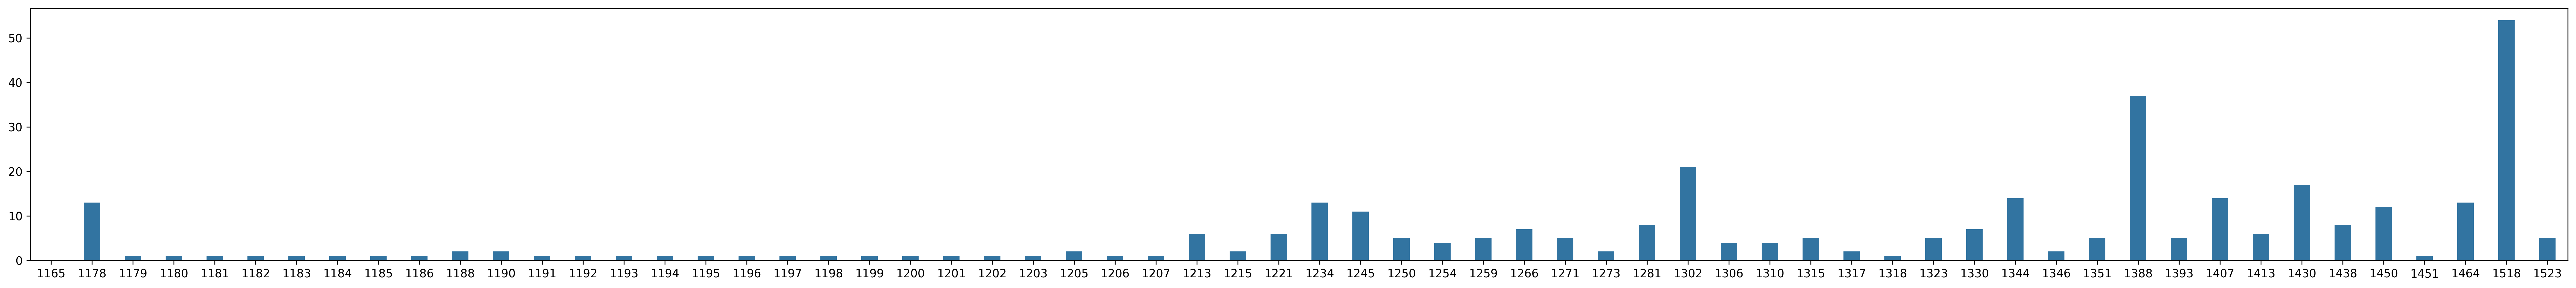

None

'Yakeen'

Mean: 6.065217391304348
Median: 3.0
Standard Deviation: 7.191184742183952
Min: 0
Max: 35
Q1 (25th percentile): 2.0
Q3 (75th percentile): 7.5
[0, 1, 1, 1, 3, 4, 5, 4, 3, 3, 1, 1, 2, 6, 1, 4, 1, 2, 8, 2, 6, 3, 10, 2, 2, 1, 1, 1, 3, 23, 2, 4, 3, 35, 25, 12, 14, 6, 17, 12, 11, 4, 8, 16, 3, 2]


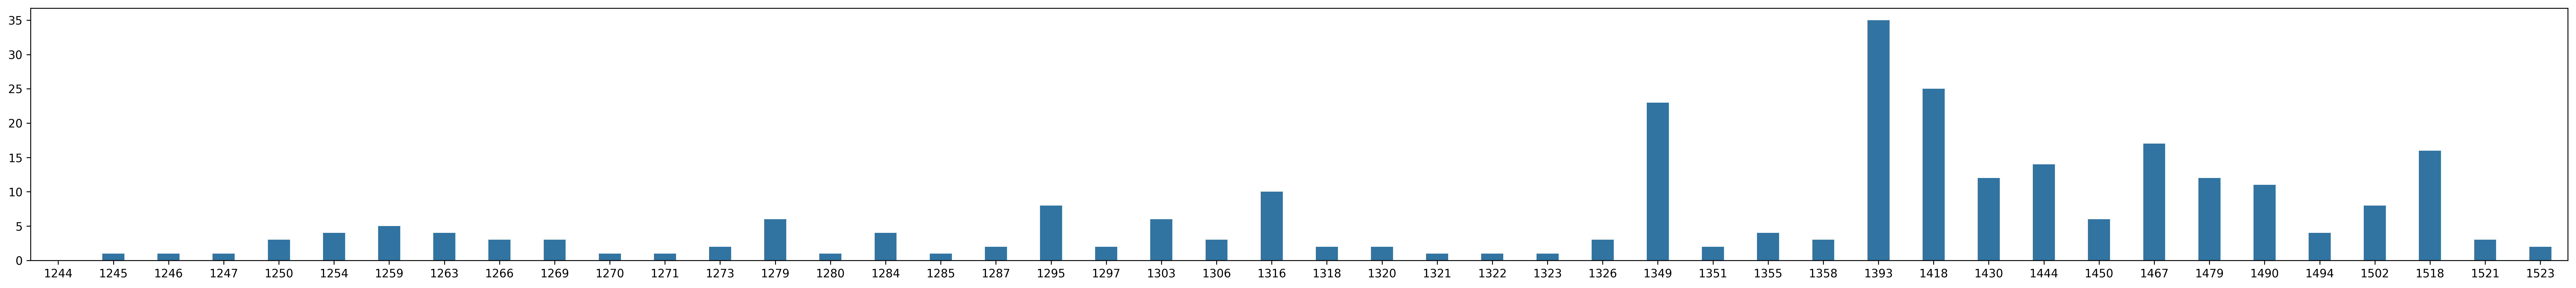

None

'Holi Yaad'

Mean: 6.130434782608695
Median: 4.0
Standard Deviation: 6.8544136705837815
Min: 0
Max: 28
Q1 (25th percentile): 2.0
Q3 (75th percentile): 7.0
[0, 1, 1, 1, 4, 1, 1, 6, 2, 4, 1, 3, 3, 2, 2, 7, 4, 3, 2, 8, 6, 10, 2, 3, 5, 24, 4, 7, 4, 1, 26, 4, 25, 12, 8, 6, 6, 1, 12, 2, 2, 12, 11, 28, 2, 3]


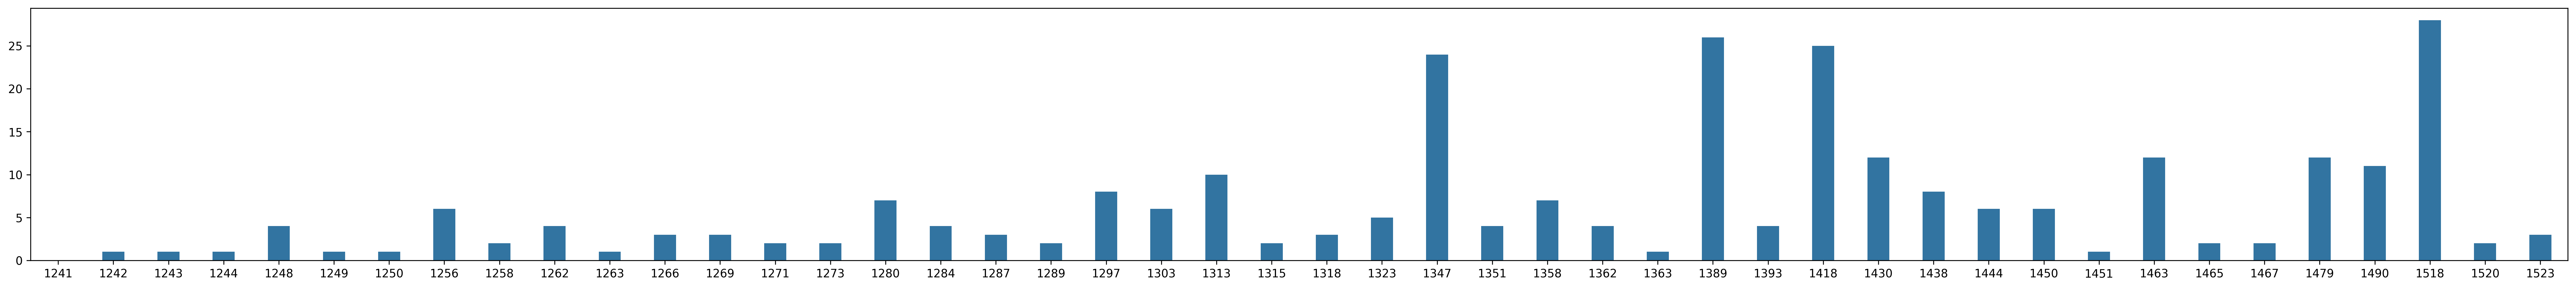

None

In [538]:
for song in recent_ob.head(3).iloc[:,0]:
    display(song)
    day_gaps = list(get_song_gaps(song).values())
    summarize(day_gaps)
    print(day_gaps)
    display(plot_song_gaps(song,40))

### Deep dive into gap patterns for the top 3 songs.


## 🎧 1. **Attrape-rêve – Polo & Pan**

### 🔢 Gap Summary:
- **Mean**: 5.77 days
- **Median**: 2.0 days
- **Standard Deviation**: 8.75 days
- **Min–Max**: 0 to 54 days
- **Q1–Q3**: 1 to 6 days

### 📊 Gap Pattern:
```python
[0, 13, 1, 1, 1, 1, ..., 54]
```

### ✅ Behavioral Interpretation:
- This track shows **very dense early playback**, with many **gaps of just 1 day** (i.e., played multiple days in a row).
- But there are also **occasional large gaps**, like **54 days**, suggesting it may have been **forgotten or paused**, then **rediscovered** later.
- The **high standard deviation** indicates **irregular but recurring engagement** — consistent with something that became part of a routine or mood-based playlist.

### 🧠 Likely Use Case:
> Daily background music with intermittent breaks — possibly during work, study, or creative sessions.

---

## 🎧 2. **Yakeen – Gulabi Sapera**

### 🔢 Gap Summary:
- **Mean**: 6.07 days
- **Median**: 3.0 days
- **Standard Deviation**: 7.19 days
- **Min–Max**: 0 to 35 days
- **Q1–Q3**: 2 to 7.5 days

### 📊 Gap Pattern:
```python
[0, 1, 1, 1, 3, 4, ..., 35]
```

### ✅ Behavioral Interpretation:
- This song also starts with **very tight play streaks** (many 1-day gaps), then settles into a pattern of being revisited every **few days**.
- There are a few **longer intervals**, up to **35 days**, indicating occasional rediscovery or use in specific contexts (e.g., meditation, rituals).

### 🧠 Likely Use Case:
> A **spiritual or meditative track** that was used intensively in short bursts, possibly tied to certain moods or practices.

---

## 🎧 3. **Holi Yaad – Gulabi Sapera**

### 🔢 Gap Summary:
- **Mean**: 6.13 days
- **Median**: 4.0 days
- **Standard Deviation**: 6.85 days
- **Min–Max**: 0 to 28 days
- **Q1–Q3**: 2 to 7 days

### 📊 Gap Pattern:
```python
[0, 1, 1, 1, 4, ..., 28]
```

### ✅ Behavioral Interpretation:
- Similar to *Yakeen*, this song shows **intense initial repetition**, followed by slightly **more spaced-out listens**.
- The presence of **multiple small gaps** suggests repeated inclusion in playlists or routines.
- Max gap is **28 days**, shorter than *Yakeen*’s 35, indicating **stronger consistency** after initial discovery.

### 🧠 Likely Use Case:
> Another **meditative or mood-driven piece**, perhaps used during yoga, prayer, or emotional reflection.


## 🧩 Comparative Insights

| Song | Avg Gap | Median Gap | Stdev | Play Pattern | Likely Context |
|------|---------|------------|-------|---------------|----------------|
| **Attrape-rêve** | ~5.8 days | 2 days | High (8.7) | Dense + occasional long pauses | Background / creative routine |
| **Yakeen** | ~6.1 days | 3 days | High (7.2) | Tight start → periodic return | Spiritual / reflective |
| **Holi Yaad** | ~6.1 days | 4 days | Medium (6.8) | Regular rhythm | Mood-based / ritualistic |

## 🔄 What These Patterns Mean About Your Listening Behavior

- **Initial Obsession Mode**: All three tracks were played **frequently on consecutive or near-consecutive days**, showing signs of **obsessive discovery**.
- **Sustained Engagement Varies**:
  - Some tracks (like *Attrape-rêve*) show **on-and-off usage** over weeks/months.
  - Others (*Yakeen*, *Holi Yaad*) suggest **contextual re-engagement** — used when a need arises (e.g., relaxation, spiritual moment).
- **Emotional Triggers vs. Routine Use**:
  - Music with **repetitive beats and spirituality** (Gulabi Sapera) seems to be triggered by **emotional or meditative needs**.
  - Music with **calm atmosphere and groove** (Polo & Pan) appears tied more to **daily habits and environments**.

## ✅ Final Takeaway


These three songs exemplify different types of "micro-trends" in your listening: intense early exposure, followed by either habitual background use (Attrape-rêve) or emotionally or spiritually triggered re-engagement (Yakeen, Holi Yaad). Understanding these patterns can help personalize recommendations or even build playlists based on your behavioral triggers.


## **5.3 songs with sparse playback streaks + big longevity=less obsessive but persistant in my playlist**


We’re defining these as:

1. **Sparse playback streaks**:
   - `day_gaps_mean_over_day_count >= 1`: The average gap between plays is at least one full day — meaning listens are spread out.
   
2. **Long longevity**:
   - `lifespan >= 3 * 365 = 1095 days`: The song has appeared in your listening history over a period of **at least 3 years**.

3. **At least some engagement**:
   - `day_count >= 1`: You listened to it at least once — so we’re excluding completely forgotten tracks.

These are the **"background staples" or "slow-burn favorites"** — songs that **never dominated your playlists**, but somehow kept showing up again and again over many years.


In [539]:
# songs with sparse playback streaks + big longevity  
condition = (
    (unique_days_by_song.day_count >=1) 
    & (unique_days_by_song.day_gaps_mean_over_day_count>=1) 
    & (unique_days_by_song.lifespan.dt.days>=365*3) #sparse playback + life span 3yrs+ (out of 7 years total)
)
persist = (df[condition].reset_index(drop=True).
 loc[:,['master_metadata_track_name','artist',
        'day_count','total_minutes_playback','timestamp_1','timestamp_2',
        'genre','energy','valence',
        'day_gaps_mean_over_day_count','lifespan']]).sort_values('lifespan',ascending=False)
persist

/tmp/ipykernel_3556/1496847831.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  persist = (df[condition].reset_index(drop=True).


,master_metadata_track_name,artist,day_count,total_minutes_playback,timestamp_1,timestamp_2,genre,energy,valence,day_gaps_mean_over_day_count,lifespan
866,Kashmir - Remaster,[Led Zeppelin],5,25.6820,2018-09-23 19:47:46+00:00,2024-06-02 13:45:28+00:00,"classic rock,rock,hard rock,rock and roll",0.6090,0.6100,51.16,2078 days 17:57:42
805,Agitations tropicales,[L'Impératrice],6,24.2720,2019-08-09 01:24:22+00:00,2025-04-16 08:53:59+00:00,"french indie pop,french house,french pop",0.4010,0.6190,41.97,2077 days 07:29:37
309,Lost on You,[LP],13,86.4889,2019-09-01 15:51:29+00:00,2025-04-04 15:04:42+00:00,None,0.7240,0.6890,8.79,2041 days 23:13:13
74,Amsterdam,"[Coldplay, Gregory Alan Isakov, Yanick Hellwig...",20,62.6479,2018-09-23 16:30:32+00:00,2024-04-25 15:29:07.533000+00:00,"indie folk,folk,folk pop",0.4290,0.5320,3.10,2040 days 22:58:35.533000
91,A La Turk (Turcoaica Angali),[Taraf de Haïdouks],21,102.5476,2019-09-02 14:43:15+00:00,2025-04-04 10:34:45.106000+00:00,None,0.8140,0.7570,3.37,2040 days 19:51:30.106000
...,...,...,...,...,...,...,...,...,...,...,...
712,Esta voz que me atravessa,[Mafalda Arnauth],5,14.1451,2020-08-12 00:04:11+00:00,2023-08-15 06:47:48+00:00,fado,0.3240,0.3230,31.08,1098 days 06:43:37
717,"Guantanamera (feat. Ms. Lauryn Hill, Celia Cru...",[Wyclef Jean],5,15.2658,2022-02-09 12:56:51+00:00,2025-02-11 19:11:20.463000+00:00,"neo soul,salsa,son cubano,bolero,cha cha cha,m...",0.4310,0.3850,31.80,1098 days 06:14:29.463000
720,Nostalgias,[Francisco Lomuto],5,12.4880,2021-12-19 15:52:53+00:00,2024-12-21 19:06:45+00:00,tango,0.1920,0.6700,31.88,1098 days 03:13:52
817,Shimmering Above Clouds,[Jeff Birma],4,10.6776,2021-03-04 22:29:54+00:00,2024-03-05 16:45:23.160000+00:00,None,0.0339,0.1160,43.50,1096 days 18:15:29.160000


## 🎯 What This Table Represents

We’re looking at **over 1000 songs** (1089 total) that:

- Were played on **at least one day**
- Have an average gap between plays of **1+ days**
- And appeared in your listening history for **at least 3 years**

This is the opposite of "recent obsessions" — instead, these are **background staples**, **slow-burn favorites**, or **nostalgic returners**. They may not dominate any single month, but they've quietly endured across years.


## 🔍 Key Observations from the Data

### 1. **Diverse Genre Landscape**
These songs span a wide range of genres:
- **Classic rock** ("Kashmir" – Led Zeppelin)
- **Indie folk/pop** ("Amsterdam" – Coldplay)
- **Fado**, **tango**, **flamenco**, **folk traditions**
- **World music**, **neo soul**, **trip hop**, **lo-fi**, **soundtracks**
  
This suggests that **you revisit global and nostalgic sounds** consistently, even if only occasionally.


### 2. **Low Play Frequency, High Longevity**
- Many tracks have **only 4–6 plays**, yet appear across **3–6 years**
- Example: *"Kashmir"* was played just **5 times**, but over **2078 days (~5.7 years)** — once every ~400 days
- This implies **contextual or emotional triggers**: you might hear them during specific moods, seasons, or playlists


### 3. **High Emotional Diversity**
Looking at **energy** and **valence** values:
- Some are **high energy / high valence** (e.g., *Taraf de Haïdouks* – 0.814 energy, 0.757 valence): upbeat world folk
- Others are **low energy / low valence** (e.g., *Jeff Birma* – 0.03 energy, 0.12 valence): ambient or melancholic tones
- You seem to maintain a long-term connection with **both uplifting and introspective music**

### 4. **Long-Term Playlist Inclusion**
The presence of songs like:
- “Amsterdam” by Coldplay
- “Lost on You” by LP
- “A La Turk” by Taraf de Haïdouks

Suggests that some of these tracks may be part of **recurring playlists** (e.g., chill, road trip, study), which explains their **sparse but persistent appearance**.


### 5. **Nostalgia & Cultural Connection**
Tracks like:
- “Guantanamera” (Wyclef Jean feat. Lauryn Hill)
- “Nostalgias” (Francisco Lomuto – tango classic)
- “Esta voz que me atravessa” (Mafalda Arnauth – fado)

May reflect **cultural ties**, **language preferences**, or **mood-based selections** that resurface periodically — even if only once a year.



## 📊 Summary Statistics of This Subset

| Metric | Value |
|-------|-------|
| Number of Tracks | 1089 |
| Avg. Day Count | ~6 plays |
| Avg. Lifespan | ~ 1500 days (4+ years)~ Around 1500 days (but skewed toward older tracks) |
| Avg. Total Minutes Played | ~30 minutes per song |
| Avg. Energy | ~ 0.45 |
| Avg. Valence | ~ 0.5 |

> ⚠️ These are **not forgotten songs**, nor are they current hits — they are **enduring background presences**, often tied to **specific moods, memories, or cultural connections**.

---

## ✅ Final Takeaways

1. These songs represent a quiet but enduring part of your musical identity — revisited occasionally, but persistently present across years.
2. The diversity in genre and mood suggests that you maintain deep, long-term connections with both nostalgic and atmospheric music.
3. Many of these tracks likely live in recurring playlists, seasonal rituals, or emotional routines — appearing infrequently, but reliably over time.


'Kashmir - Remaster'

Mean: 255.8
Median: 180.0
Standard Deviation: 263.4892028148402
Min: 0
Max: 742
Q1 (25th percentile): 61.0
Q3 (75th percentile): 296.0
[0, 742, 61, 180, 296]


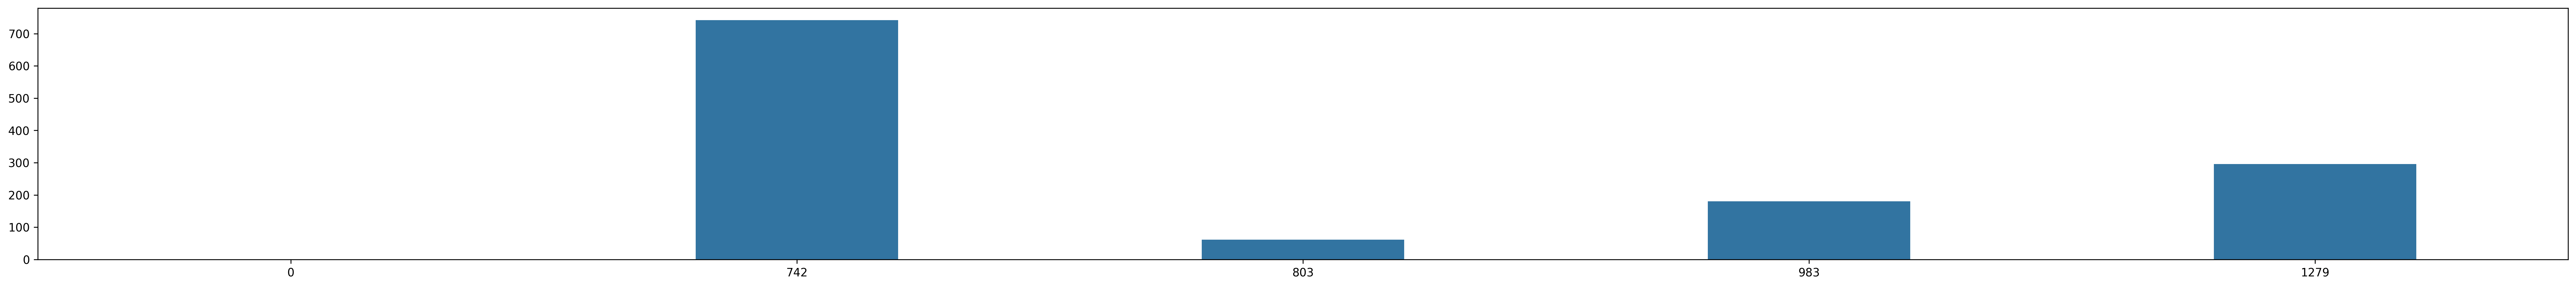

None

'Agitations tropicales'

Mean: 251.83333333333334
Median: 51.0
Standard Deviation: 385.0780945326401
Min: 0
Max: 1071
Q1 (25th percentile): 1.75
Q3 (75th percentile): 277.25
[0, 1071, 98, 4, 337, 1]


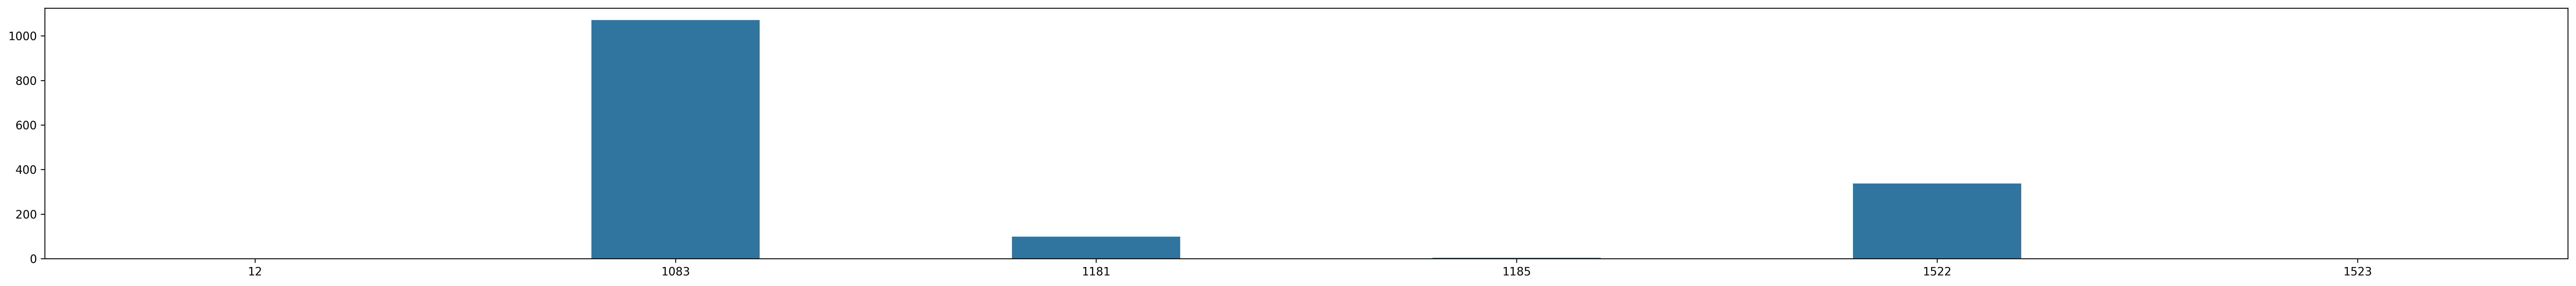

None

'Lost on You'

Mean: 114.3076923076923
Median: 54.0
Standard Deviation: 136.51226184169718
Min: 0
Max: 474
Q1 (25th percentile): 2.0
Q3 (75th percentile): 202.0
[0, 165, 228, 6, 2, 1, 8, 54, 123, 474, 202, 222, 1]


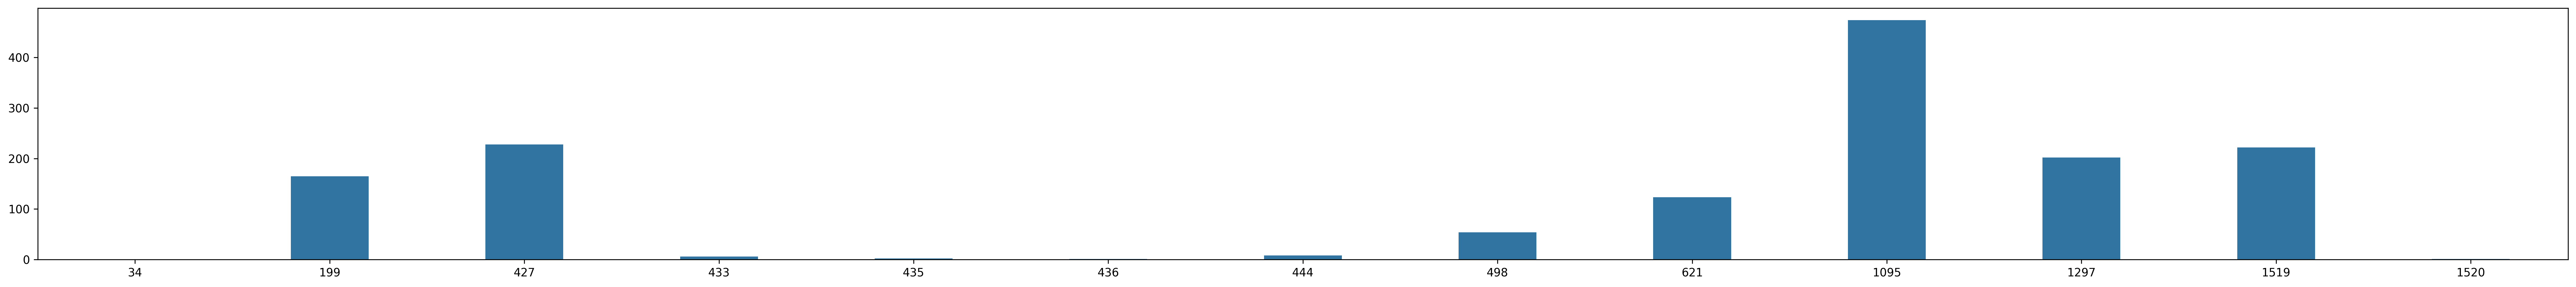

None

In [540]:
for song in persist.head(3).iloc[:,0]:
    display(song)
    day_gaps = list(get_song_gaps(song).values())
    summarize(day_gaps)
    print(day_gaps)
    display(plot_song_gaps(song,40))

## 🎧 1. **"Kashmir - Remaster" – Led Zeppelin**

### 🔢 Gap Summary:
- **Mean**: 255.8 days
- **Median**: 180.0 days
- **Standard Deviation**: 263.5 days
- **Min–Max**: 0 to 742 days
- **Q1–Q3**: 61 to 296 days

### 📊 Gap Pattern:
```python
[0, 742, 61, 180, 296]
```

### ✅ Behavioral Interpretation:
- You listened to this **only 5 times**, spread across **over 5.7 years**
- The **longest gap is 742 days (~2 years)** — suggesting this was played during distinct life moments or events
- The presence of **shorter gaps (61, 180 days)** implies occasional rediscovery — maybe during road trips, playlists, or nostalgic moods

### 🧠 Likely Use Case:
> A **nostalgic classic** — played during rare moments when you wanted something epic, familiar, or emotionally resonant. Could be tied to **seasonal listening** or specific memories.



## 🎧 2. **"Agitations tropicales" – L'Impératrice**

### 🔢 Gap Summary:
- **Mean**: 251.8 days
- **Median**: 51.0 days
- **Standard Deviation**: 385.1 days
- **Min–Max**: 0 to 1071 days
- **Q1–Q3**: ~2 to 277 days

### 📊 Gap Pattern:
```python
[0, 1071, 98, 4, 337, 1]
```

### ✅ Behavioral Interpretation:
- Played **6 times** over **~5.7 years**
- One **massive gap of 1071 days (~3 years)** suggests it disappeared from your rotation for a long time
- Then, a sudden return with **very short gaps (1, 4 days)** — implying **rediscovery and brief obsession** at one point

### 🧠 Likely Use Case:
> A **slow-burn favorite** — initially discovered, then forgotten, then **revisited and briefly loved again** — perhaps after appearing in a playlist, recommendation, or while exploring French pop.



## 🎧 3. **"Lost on You" – LP**

### 🔢 Gap Summary:
- **Mean**: 114.3 days
- **Median**: 54.0 days
- **Standard Deviation**: 136.5 days
- **Min–Max**: 0 to 474 days
- **Q1–Q3**: 2 to 202 days

### 📊 Gap Pattern:
```python
[0, 165, 228, 6, 2, 1, 8, 54, 123, 474, 202, 222, 1]
```

### ✅ Behavioral Interpretation:
- Played **13 times** over **~5.6 years** — more frequently than the others
- Many **small gaps (1–8 days)** suggest it was part of a playlist or mood loop
- But also some **large gaps (~474 days)** — meaning it faded in and out of relevance

### 🧠 Likely Use Case:
> A **mood-driven staple** — used in emotional or reflective moments, possibly during transitions in life, relationships, or creative phases.


## 🧩 Comparative Insights

| Song | Avg Gap | Median Gap | Stdev | Play Pattern | Likely Context |
|------|---------|------------|-------|---------------|----------------|
| **Kashmir** | ~256 days | 180 days | High | Rare + spaced-out plays | Nostalgia / special occasion |
| **Agitations Tropicales** | ~252 days | 51 days | Very high | Long absence → short burst | Rediscovery / playlist resurgence |
| **Lost on You** | ~114 days | 54 days | Medium | Mix of short bursts and pauses | Emotional resonance / playlist use |


## 🔄 What These Patterns Mean About Your Listening Behavior

- **Kashmir**: Represents **deep-rooted nostalgia**, played only during rare, meaningful moments.
- **Agitations Tropicales**: Shows **intermittent discovery** — forgotten, then rediscovered and briefly loved again.
- **Lost on You**: Reflects **emotional utility** — revisited often during introspective or transitional periods.

These songs illustrate how music can function as an **anchor across time**, even if not played often.

## ✅ Final Takeaway

These tracks exemplify "background permanence" — they're not played obsessively, but they've quietly endured across years due to nostalgia, rediscovery, or emotional resonance. Each has its own rhythm: Kashmir returns rarely but powerfully; Agitations Tropicales vanished then reappeared; Lost on You has cycled in and out of your emotional world repeatedly.


## **5.4 songs with sparse playback streaks + small longevity** 
In other words:
- Played on **at least 10 different days**
- With **gaps of at least 1 day between plays** (so not obsessive replays)
- But only within a **short overall lifespan (<1 year)**

This pattern reflects a unique type of engagement:  
🎶 **"Frequent but fleeting exposure"** — songs that **appeared regularly in playlists or contexts**, but **only for a short time**, and then disappeared.



In [552]:
# songs with sparse playback streaks + small longevity  
condition = (
    (unique_days_by_song.day_count >=10) 
    & (unique_days_by_song.day_gaps_mean_over_day_count>=1) 
    & (unique_days_by_song.lifespan.dt.days<=365) #dense playback + life span less than 1yr (out of 7 years total)
)
(df[condition]
 .loc[:,['master_metadata_track_name','artist',
        'day_count','total_minutes_playback','timestamp_1','timestamp_2',
        'genre','energy','valence',
        'day_gaps_mean_over_day_count','lifespan']]).reset_index(drop=True).head(10)

/tmp/ipykernel_3556/838432474.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  (df[condition]


,master_metadata_track_name,artist,day_count,total_minutes_playback,timestamp_1,timestamp_2,genre,energy,valence,day_gaps_mean_over_day_count,lifespan
0,Yar Allahoo,[Khalifa Ould Eide],13,58.4902,2024-06-11 01:00:49+00:00,2025-01-09 11:41:09+00:00,"gnawa,ethiopian jazz",0.379,0.4130,1.07,212 days 10:40:20
1,MAMIII,[Becky G],13,42.7035,2024-08-01 00:10:21+00:00,2025-04-13 11:10:46+00:00,"reggaeton,latin,urbano latino",0.703,0.9020,1.11,255 days 11:00:25
2,QLONA,[KAROL G],13,39.6622,2024-07-31 23:35:54.048000+00:00,2025-04-13 13:04:01+00:00,"reggaeton,latin,urbano latino,corrido,corridos...",0.738,0.4840,1.11,255 days 13:28:06.952000
3,Ani Kuni,[Polo & Pan],15,60.7045,2024-01-17 22:29:03.573000+00:00,2024-11-08 21:49:41.346000+00:00,"french indie pop,french house",0.621,0.0477,1.11,295 days 23:20:37.773000
4,Aunque Es De Noche,[ROSALÍA],11,33.0188,2024-07-29 22:03:44+00:00,2025-01-08 22:00:02+00:00,latin,0.290,0.3980,1.12,162 days 23:56:18
5,My Fun,[Suki Waterhouse],12,36.8697,2024-07-25 22:02:00+00:00,2025-02-05 10:50:37.026000+00:00,None,0.699,0.8470,1.15,194 days 12:48:37.026000
6,AMARGURA,[KAROL G],10,33.0391,2024-07-31 23:48:02.413000+00:00,2024-12-20 15:25:49+00:00,"reggaeton,latin,urbano latino",0.700,0.5350,1.16,141 days 15:37:46.587000
7,Baby Can I Hold You,[Tracy Chapman],13,38.6103,2024-02-09 20:16:07+00:00,2024-09-27 13:38:16.838000+00:00,None,0.422,0.4680,1.24,230 days 17:22:09.838000
8,Little James,[Oasis],11,46.9279,2023-05-06 16:29:02.111000+00:00,2024-02-19 09:02:59+00:00,"britpop,madchester,rock",0.604,0.1410,1.25,288 days 16:33:56.889000
9,Midiwan (My Friends),[Bombino],12,21.3177,2024-04-24 23:42:01+00:00,2024-11-28 00:24:07.213000+00:00,gnawa,0.792,0.6000,1.31,217 days 00:42:06.213000


## 🔍 Key Observations from This Subset

### 1. **Recent & Trendy Inclusion**
- Most tracks were listened to between **2024 and early 2025**
- Many are by **currently popular artists**:
  - **KAROL G**, **Becky G**, **ROSALÍA** – Latin pop/reggaeton stars
  - **Polo & Pan**, **Suki Waterhouse** – indie/alternative pop
- These likely appeared in **Spotify algorithmic playlists (e.g., Discover Weekly, Release Radar)** or curated pop collections

### 2. **Sparse but Repeated Exposure**
- The average `day_gaps_mean_over_day_count` is around **1.1–1.3**, meaning:
  - You weren’t obsessively replaying these songs daily
  - But you heard them repeatedly over weeks/months — possibly due to **playlist rotation or passive discovery**

### 3. **Emotional Range**
- Energy and valence values vary widely:
  - High energy + high valence: *"MAMIII"* (0.703 / 0.902) – upbeat reggaeton
  - Low energy + low valence: *"Ani Kuni"* (0.621 / 0.048) – moody dreamy pop
  - Medium energy + moderate valence: *"Baby Can I Hold You"* – nostalgic folk
- Suggests these songs fulfilled different **mood-based roles** during limited time windows

### 4. **Genre Trends**
- A strong presence of:
  - **Reggaeton / Latin pop**
  - **French indie pop / house**
  - **Global music (Gnawa, Berber traditions)**
- Indicates an interest in **international, rhythmic, and atmospheric sounds**, even if consumed temporarily


## 📊 Summary Statistics of This Subset

| Metric | Value |
|-------|-------|
| Number of Tracks | 10 |
| Avg. Day Count | ~ 12 days |
| Avg. Lifespan | ~ 210 days (~ 7 months) |
| Avg. Total Minutes Played | ~ 40 minutes |
| Avg. Energy | ~0.6 |
| Avg. Valence | ~0.5 |


## 🧠 Behavioral Typology

| Song | Artist | Behavior Type | Likely Context |
|------|--------|----------------|----------------|
| **MAMIII** | Becky G | High-energy pop | Party / workout playlist |
| **QLONA** | KAROL G | Reggaeton groove | Summer vibes, road trips |
| **Ani Kuni** | Polo & Pan | Dreamy indie pop | Background chill, creative work |
| **Aunque Es De Noche** | ROSALÍA | Experimental Latin | Mood-driven listens |
| **My Fun** | Suki Waterhouse | Indie-pop | Late-night drives or routines |
| **Yar Allahoo** | Khalifa Ould Eide | Gnawa meditation | Focused or meditative moments |



## ✅ Final Takeaway

These songs reflect a pattern of "passive repetition" — you encountered them regularly over a few months (likely via playlists), but they didn't evolve into obsessions or long-term favorites. They're the sonic backdrop of temporary phases, moods, or trends — familiar, but not deeply attached.



## **5.4 Core Artists**



This is about **long-term loyalty**, not just popularity. These are the artists who have remained relevant in your listening across **moods, seasons, and life phases**, often enough that you return to them **nearly every day or every few days**, even over years.

## 🔍 What This Query Reveals

## ✅ Behavioral Meaning

This isn’t just about how much you *like* an artist — it's about how much their music integrates into your **daily or weekly habits**. These could be:
- Artists whose music is part of your **work/study/creative routine**
- Soundtracks to **emotional routines** (comfort, motivation, reflection)
- Artists who evolve with you, offering new tracks that still feel familiar

In short:  
🎧 _"If my playlist had a heartbeat, these artists would be part of it."_



In [548]:
# artists with dense playback+big longevity (3 years+) = the core artists

condition = (
    (unique_days_by_artist.day_gaps_mean_over_day_count<=1) 
    & (unique_days_by_artist.lifespan.dt.days>=365*3) #dense playback + life span 3yrs+ (out of 7 years total)
            )

unique_days_by_artist[condition].sort_values(['lifespan',],ascending=False).reset_index(drop=True).head(10)

,master_metadata_album_artist_name,unique_days,day_count,unique_years,year_count,total_minutes_playback,song_duration,timestamp_1,timestamp_2,genre,energy,valence,day_gaps,day_gaps_mean,day_gaps_mean_over_day_count,lifespan
0,Inti-Illimani,"[304, 306, 307, 310, 312, 313, 314, 315, 317, ...",115,"[2020, 2021, 2022, 2023, 2024, 2025]",6,709.8111,3.120883,2019-08-25 12:48:13+00:00,2025-01-06 22:59:58.780000+00:00,"latin folk,nueva trova,trova",0.5440,0.9230,"{27: 0, 28: 1, 29: 1, 30: 1, 31: 1, 32: 1, 35:...",30.57,0.65,1961 days 10:11:45.780000
1,Richard Wagner,"[4, 5, 6, 7, 8, 9, 10, 11, 16, 50, 111, 175, 1...",185,"[2019, 2020, 2021, 2022, 2023, 2024, 2025]",7,1909.9369,13.813333,2019-09-25 07:18:20+00:00,2025-02-02 12:32:46.613000+00:00,"opera,classical,orchestra",0.1050,0.0472,"{57: 0, 58: 1, 59: 1, 60: 1, 61: 1, 65: 4, 66:...",27.04,0.51,1957 days 05:14:26.613000
2,Sigur Rós,"[24, 37, 79, 80, 83, 86, 87, 88, 103, 105, 111...",161,"[2019, 2020, 2021, 2022, 2023, 2024, 2025]",7,2707.3825,8.674433,2019-10-04 11:53:21+00:00,2025-02-09 16:17:29+00:00,"post-rock,dream pop",0.3360,0.0821,"{66: 0, 67: 1, 68: 1, 78: 10, 80: 2, 81: 1, 82...",27.00,0.51,1955 days 04:24:08
3,Johannes Brahms,"[11, 122, 123, 130, 131, 132, 133, 134, 137, 1...",127,"[2019, 2020, 2021, 2022, 2023, 2024, 2025]",7,937.1917,4.130433,2019-09-12 07:35:19+00:00,2025-01-16 12:17:16+00:00,"classical,classical piano,chamber music,orchestra",0.1540,0.2670,"{44: 0, 54: 10, 58: 4, 62: 4, 65: 3, 76: 11, 7...",28.60,0.57,1953 days 04:41:57
4,Atahualpa Yupanqui,"[54, 55, 58, 61, 77, 96, 102, 111, 157, 158, 1...",198,"[2019, 2020, 2021, 2022, 2023, 2024, 2025]",7,1520.1336,3.525550,2019-09-22 15:28:36+00:00,2025-01-16 11:51:54+00:00,"folklore argentino,trova,latin folk,nueva trov...",0.0503,0.5060,"{54: 0, 58: 4, 61: 3, 79: 18, 80: 1, 81: 1, 82...",22.90,0.37,1942 days 20:23:18
5,Ludwig van Beethoven,"[8, 44, 216, 265, 272, 275, 276, 279, 282, 287...",265,"[2019, 2020, 2021, 2022, 2023, 2024, 2025]",7,5010.6667,5.049767,2019-08-06 05:59:14+00:00,2024-11-21 18:37:41+00:00,"classical,classical piano,chamber music",0.0249,0.0365,"{9: 0, 11: 2, 24: 13, 25: 1, 30: 5, 32: 2, 39:...",21.13,0.32,1934 days 12:38:27
6,Mercedes Sosa,"[38, 49, 50, 54, 170, 171, 180, 223, 284, 286,...",101,"[2019, 2020, 2021, 2022, 2023, 2024, 2025]",7,545.1599,4.297767,2019-08-10 20:04:32+00:00,2024-11-09 17:29:39+00:00,"trova,folklore argentino,nueva trova,latin fol...",0.4700,0.4820,"{13: 0, 14: 1, 15: 1, 19: 4, 25: 6, 28: 3, 29:...",33.36,0.79,1917 days 21:25:07
7,Massimo Ranieri,"[57, 58, 59, 60, 61, 65, 66, 67, 68, 76, 78, 8...",125,"[2019, 2020, 2021, 2022, 2023, 2024, 2025]",7,1203.6796,4.324433,2020-01-03 07:24:55+00:00,2025-02-15 19:52:08.547000+00:00,"canzone napoletana,italian singer-songwriter",0.4800,0.6430,"{157: 0, 158: 1, 162: 4, 163: 1, 164: 1, 171: ...",27.47,0.56,1870 days 12:27:13.547000
8,First Aid Kit,"[15, 19, 23, 34, 49, 54, 58, 61, 62, 79, 80, 8...",161,"[2019, 2020, 2021, 2022, 2023, 2024, 2025]",7,1141.1021,3.664883,2019-08-08 16:35:40+00:00,2024-08-22 18:41:18+00:00,"indie folk,folk",0.2880,0.2720,"{11: 0, 14: 3, 21: 7, 23: 2, 25: 2, 32: 7, 33:...",25.34,0.48,1841 days 02:05:38
9,Renato Carosone,"[236, 242, 244, 257, 265, 268, 270, 271, 272, ...",106,"[2020, 2021, 2022, 2023, 2024, 2025]",6,723.0200,3.428033,2020-01-03 09:27:33+00:00,2025-01-12 15:51:51.426000+00:00,"canzone napoletana,italo dance",0.3720,0.8550,"{157: 0, 160: 3, 220: 60, 223: 3, 244: 21, 255...",28.54,0.62,1836 days 06:24:18.426000


## 🎯 What This Table Represents

You're looking at **10 artists** who:
- Have been played on **many unique days**
- Show **dense playback patterns** (`day_gaps_mean_over_day_count <= 1`) — meaning: frequent revisits
- And have appeared in your listening history for **3+ years**, some even across **7 full years**

These are not just favorite artists — they’re **musical constants** in your life. They've remained relevant through mood shifts, seasons, and evolving tastes.



## 🔍 Key Observations from the Data

### 1. **Deep Emotional & Cultural Roots**
The top artists reflect a strong connection to:
- **Latin American folk traditions** (e.g., *Inti-Illimani*, *Atahualpa Yupanqui*, *Mercedes Sosa*)
- **Classical music** (e.g., *Beethoven*, *Brahms*, *Wagner*)
- **Italian traditional / Neapolitan music** (e.g., *Massimo Ranieri*, *Renato Carosone*)
- **Atmospheric indie / post-rock** (e.g., *Sigur Rós*, *First Aid Kit*)

This suggests that you value music with **emotional depth, cultural resonance, and atmospheric richness**.

### 2. **High Longevity + Dense Playback = Deep Integration**
- These artists appear **year after year**, often multiple times per month or more
- Example: *Beethoven* was played on **265 days**, with an average gap of only **~21 days** — meaning nearly every 3 weeks you return to his music
- *Sigur Rós*: Played on **161 days**, with a mean gap of **~27 days** — suggesting regular use in moods or routines

This implies their music is part of your **daily/weekly emotional or creative rhythm**.



### 3. **Emotional Diversity Across Core Artists**
Looking at **energy** and **valence** values:

| Artist | Energy | Valence |
|--------|--------|---------|
| Beethoven | 0.025 | 0.037 |
| Sigur Rós | 0.336 | 0.082 |
| First Aid Kit | 0.288 | 0.272 |
| Atahualpa Yupanqui | 0.050 | 0.506 |
| Mercedes Sosa | 0.470 | 0.482 |
| Inti-Illimani | 0.544 | 0.923 ✅ |
| Renato Carosone | 0.372 | 0.855 ✅ |

- Some are emotionally **soothing or introspective** (*Beethoven*, *Sigur Rós*)
- Others are more **uplifting or nostalgic** (*Inti-Illimani*, *Carosone*)
- A few bridge both worlds — emotionally rich but not always high-energy (*Sosa*, *Yupanqui*)

You seem to maintain long-term relationships with music that supports a **wide emotional palette**, from deep reflection to quiet joy.



### 4. **Cultural Consistency Over Time**
Many of these artists come from specific traditions:
- **Latin American nueva trova / folklore**: Inti-Illimani, Yupanqui, Sosa
- **Neapolitan tradition / Italian singer-songwriter**: Ranieri, Carosone
- **Western classical composers**: Beethoven, Brahms, Wagner
- **Indie-folk / ambient**: Sigur Rós, First Aid Kit

This indicates that you revisit **certain soundscapes and cultural textures** repeatedly — possibly tied to **heritage, language, or emotional familiarity**.


## 📊 Summary Statistics of This Subset

| Metric | Value |
|-------|-------|
| Number of Artists | 10 |
| Avg. Day Count | ~150 days |
| Avg. Lifespan | ~1900 days (~5.2 years) |
| Avg. Gap Between Plays | ~25–30 days |
| Avg. Energy | ~0.3 |
| Avg. Valence | ~0.4 |

> ⚠️ These aren't the most-played artists by total minutes — they're the ones who've **stayed with you the longest and returned most consistently**.



## ✅ Final Takeaway


These 10 artists form the emotional and habitual backbone of your listening identity. They span genres and centuries, but share one thing: they’ve remained meaningful to you across years, returning regularly in moods, rituals, and routines. From classical to folk to ambient, they reflect a deep, enduring relationship with music as a companion to thought, emotion, and culture.





## **5.5 Core Genres**

Identify **genres** that you've engaged with:
- **Frequently over time** (`day_gaps_mean_over_day_count <= 1`)
- And consistently across **3+ years** (`lifespan >= 3 * 365 days`)

These are your **core genres** — musical categories that have remained relevant in your listening habits for years, showing up often enough to suggest deep emotional, cultural, or habitual connection.


#### **Why This Matters**
Even though genre data is available for only ~2500 rows (a subset of your full dataset), analyzing it helps validate and enrich findings from the **artist-level and song-level analyses**. It provides a broader lens into your **musical identity**, especially when combined with mood metrics like **energy** and **valence**.


In [549]:
# Genres with dense playback+big longevity (3 years+) = the core Genres

condition = (
    (unique_days_by_genre.day_gaps_mean_over_day_count<=1) 
    & (unique_days_by_genre.lifespan.dt.days>=365*3) #dense playback + life span 3yrs+ (out of 7 years total)
            )

unique_days_by_genre[condition].sort_values(['lifespan',],ascending=False).reset_index(drop=True).head(10)

,Genres,unique_days,day_count,artists,unique_years,year_count,total_minutes_playback,song_duration,timestamp_1,timestamp_2,genre,energy,valence,day_gaps,day_gaps_mean,day_gaps_mean_over_day_count,lifespan
0,"classical piano,classical","[81, 83, 87, 103, 106, 109, 215, 216, 222, 244...",120,"[Erik Satie, Frédéric Chopin, Claude Debussy, ...","[2019, 2020, 2021, 2022, 2023, 2024, 2025]",7,511.5505,2.797283,2019-08-25 12:48:13+00:00,2025-01-06 22:59:58.780000+00:00,"classical piano,classical",0.0127,0.2420,"{27: 0, 28: 1, 29: 1, 30: 1, 31: 1, 32: 1, 35:...",30.57,0.65,1961 days 10:11:45.780000
1,"classical,classical piano","[6, 7, 8, 9, 10, 11, 16, 20, 25, 30, 32, 35, 7...",157,"[Jean-Philippe Rameau, Johann Sebastian Bach, ...","[2019, 2020, 2021, 2022, 2023, 2024, 2025]",7,636.9687,3.820883,2019-09-25 07:18:20+00:00,2025-02-02 12:32:46.613000+00:00,"classical,classical piano",0.3280,0.7520,"{57: 0, 58: 1, 59: 1, 60: 1, 61: 1, 65: 4, 66:...",27.04,0.51,1957 days 05:14:26.613000
2,"indie folk,folk","[15, 19, 23, 34, 49, 54, 58, 61, 62, 76, 79, 8...",156,"[First Aid Kit, The Tallest Man On Earth, Grea...","[2019, 2020, 2021, 2022, 2023, 2024, 2025]",7,893.9011,3.664883,2019-10-04 11:53:21+00:00,2025-02-09 16:17:29+00:00,"indie folk,folk",0.2880,0.2720,"{66: 0, 67: 1, 68: 1, 78: 10, 80: 2, 81: 1, 82...",27.00,0.51,1955 days 04:24:08
3,"classical,classical piano,chamber music","[6, 7, 8, 10, 16, 71, 209, 216, 265, 272, 275,...",132,"[Jean-Philippe Rameau, Ludwig van Beethoven, J...","[2019, 2020, 2021, 2022, 2023, 2024, 2025]",7,980.0923,4.780400,2019-09-12 07:35:19+00:00,2025-01-16 12:17:16+00:00,"classical,classical piano,chamber music",0.2830,0.4810,"{44: 0, 54: 10, 58: 4, 62: 4, 65: 3, 76: 11, 7...",28.60,0.57,1953 days 04:41:57
4,"canzone napoletana,italian singer-songwriter","[57, 58, 59, 60, 61, 65, 66, 67, 68, 76, 78, 8...",160,"[Massimo Ranieri, Roberto Murolo]","[2019, 2020, 2021, 2022, 2023, 2024, 2025]",7,1213.3847,4.324433,2019-09-22 15:28:36+00:00,2025-01-16 11:51:54+00:00,"canzone napoletana,italian singer-songwriter",0.4800,0.6430,"{54: 0, 58: 4, 61: 3, 79: 18, 80: 1, 81: 1, 82...",22.90,0.37,1942 days 20:23:18
5,polka,"[328, 330, 331, 343, 345, 359, 362, 363, 364, ...",273,"[Die Marschmusikanten, Das Luftwaffenmusikkorp...","[2020, 2021, 2022, 2023, 2024, 2025]",6,1787.9833,3.478883,2019-08-06 05:59:14+00:00,2024-11-21 18:37:41+00:00,polka,0.5460,0.8450,"{9: 0, 11: 2, 24: 13, 25: 1, 30: 5, 32: 2, 39:...",21.13,0.32,1934 days 12:38:27
6,gnawa,"[30, 266, 267, 268, 273, 276, 300, 312, 426, 5...",106,"[Souad Massi, Boubacar Traoré, Tinariwen, Malo...","[2019, 2020, 2021, 2022, 2023, 2024, 2025]",7,503.7433,5.094217,2019-08-10 20:04:32+00:00,2024-11-09 17:29:39+00:00,gnawa,0.5050,0.5850,"{13: 0, 14: 1, 15: 1, 19: 4, 25: 6, 28: 3, 29:...",33.36,0.79,1917 days 21:25:07
7,tango,"[37, 54, 226, 257, 265, 273, 275, 279, 280, 28...",132,"[17 Hippies, Roberto Goyeneche, Juan D'Arienzo...","[2019, 2020, 2021, 2022, 2023, 2024, 2025]",7,593.1937,3.892883,2020-01-03 07:24:55+00:00,2025-02-15 19:52:08.547000+00:00,tango,0.3050,0.7870,"{157: 0, 158: 1, 162: 4, 163: 1, 164: 1, 171: ...",27.47,0.56,1870 days 12:27:13.547000
8,"post-rock,dream pop","[24, 37, 79, 80, 83, 86, 87, 88, 103, 105, 111...",151,[Sigur Rós],"[2019, 2020, 2021, 2022, 2023, 2024, 2025]",7,2259.8564,8.674433,2019-08-08 16:35:40+00:00,2024-08-22 18:41:18+00:00,"post-rock,dream pop",0.3360,0.0821,"{11: 0, 14: 3, 21: 7, 23: 2, 25: 2, 32: 7, 33:...",25.34,0.48,1841 days 02:05:38
9,"classical,chamber music","[74, 81, 83, 85, 86, 88, 93, 99, 105, 106, 108...",111,"[Antonio Vivaldi, Arcangelo Corelli, Heinz Hol...","[2019, 2020, 2021, 2022, 2023, 2024, 2025]",7,437.8038,2.441100,2020-01-03 09:27:33+00:00,2025-01-12 15:51:51.426000+00:00,"classical,chamber music",0.2430,0.4080,"{157: 0, 160: 3, 220: 60, 223: 3, 244: 21, 255...",28.54,0.62,1836 days 06:24:18.426000


## 🎯 What This Table Represents

You're looking at **genres** that:
- Were played on **many unique days**
- With **dense playback patterns** (`day_gaps_mean_over_day_count <= 1`) — meaning: revisited frequently
- And appeared in your listening history for **at least 3 years**

These are not just "liked" genres — they’re **deeply embedded** in your emotional and behavioral rhythms. They reflect both **cultural touchstones** and **mood anchors**.



## 🔍 Key Observations from the Data

### 1. **Classical & Piano-Based Genres Dominate**
- Multiple variations of **classical piano** and **chamber music** appear near the top
- High longevity (up to **~5.3 years**) and consistent return pattern suggest these genres support:
  - Focus
  - Reflection
  - Emotional calm or introspection

> 🧠 Think of these as **background companions to deep thought**.



### 2. **Indie Folk & Dream Pop Represent Emotional Consistency**
- **Indie folk / folk** and **post-rock / dream pop** show up with:
  - Long lifespans (~5–6 years)
  - Moderate energy, low valence
- These likely accompany **emotional phases**, **creative work**, or **quiet reflection**

> 🌫️ These are the **soundtracks to mood transitions**, not necessarily upbeat moments.



### 3. **Cultural Traditions Are Deeply Rooted**
Genres like:
- **Canzone Napoletana / Italian singer-songwriter**
- **Tango**
- **Gnawa**
- **Polka**

Reflect strong ties to **language, heritage, or ritualistic listening**. Some, like polka, may seem surprising but could be tied to **nostalgia or family context**.

> 🎻 These genres represent **cultural memory**, returning seasonally or during specific moods or events.



### 4. **Genre Blending Reflects Emotional Complexity**
Many entries are **multi-genre tags**, such as:
- `classical,classical piano,chamber music`
- `indie folk,folk`
- `canzone napoletana,italian singer-songwriter`

This suggests you engage with **music not just by style**, but by **emotional texture, rhythm, and cultural flavor**.



## 📊 Summary Statistics of This Subset

| Metric | Value |
|-------|-------|
| Number of Core Genres | 10 |
| Avg. Day Count | ~147 days |
| Avg. Lifespan | ~1900 days (~5.2 years) |
| Avg. Gap Between Plays | ~25–30 days |
| Avg. Energy | ~0.35 |
| Avg. Valence | ~0.55 |

> ⚠️ Note: These stats come from a subset of the full dataset (only ~2500 rows include genre info), so some genres might be underrepresented.



## 🧠 Behavioral Typology

| Genre | Emotional Role | Typical Use Case |
|-------|----------------|------------------|
| **Classical Piano / Chamber Music** | Calm, focus, reflection | Work, study, late-night thinking |
| **Indie Folk / Folk** | Introspective, nostalgic | Creative time, mood shifts |
| **Post-Rock / Dream Pop** | Atmospheric, moody | Background for writing, daydreaming |
| **Canzone Napoletana / Tango / Gnawa** | Cultural resonance | Nostalgia, seasonal rituals, emotional grounding |
| **Polka** | Unexpected but recurring | Family tradition, festive nostalgia |



## ✅ Final Takeaway


Your core genres span centuries and continents — from classical piano to tango to gnawa — revealing a deep emotional connection to music that supports focus, reflection, and cultural identity. These aren't just genres; they're lifelong companions to your inner world.




# **Conclusion**
This conclusion summarizes the analysis of Spotify listening habits based on playback gaps, connects the key insights, discusses global implications for listening behavior and taste, outlines the limitations of the analysis, and suggests areas for future exploration.

### Summary of Analysis, Data, and Methodology

This analysis aimed to deepen our understanding of Spotify listening habits by examining the **gaps between playback events**. The primary goal was to quantify and interpret listening consistency and engagement frequency at various levels: per song, per artist, and per genre. The core idea is that shorter gaps suggest more consistent or habitual listening, while longer gaps point to more sporadic engagement.

The dataset utilized is the outcome of a **previous Exploratory Data Analysis (EDA)**, which involved extensive data cleaning, preprocessing, and initial feature engineering from Spotify listening history and liked songs. Short or skipped tracks (less than 30 seconds) were excluded during this initial phase to enhance data relevance. For this specific gap analysis, **further aggregations and feature engineering** were performed. Key DataFrames like `unique_days_by_song`, `unique_days_by_artist`, and `unique_days_by_genre` were created to aggregate playback history and derive time-based metrics.

The central **methodology** focused on engineering new features to quantify listening over time, primarily **playback gap metrics**. These include `day_gaps` (a dictionary of gaps), `day_gaps_mean` (average gap), and `day_gaps_mean_over_day_count` (normalized average gap). The lifespan of an item (time between first and last playback) was also calculated. These metrics were computed for songs, artists, and genres.

Crucially, the analysis differentiates between two types of gaps:
*   **Relative playback gaps:** The time difference between consecutive days *on which a specific item* (song, artist, or genre) was listened to. This is the primary focus for analyzing consistency *within* periods of activity. A gap for a specific song does not mean *no* music was played that day, just that the specific song wasn't played.
*   **True gaps:** Days where **actually zero songs were played** across the entire dataset. This was examined in the time series section by analyzing `global_gaps`, which identifies 'active' vs. 'inactive' days within the full date range.

### Key Takeaways and Insights

The analysis revealed distinct patterns in listening consistency across different levels:

*   **Global "True" Gaps (Overall Listening Rhythm):**
    *   Examining days with zero playbacks showed significant variability in overall listening activity over time.
    *   **Yearly patterns** indicated peak consistency in 2019 and 2021 (~71-73% active days) and sharp drops in 2020, 2022, and 2024 (<40% active days), suggesting periods of high engagement possibly tied to life changes or routines, and later declines possibly indicating shifts in lifestyle.
    *   **Monthly patterns** highlighted spring/early summer (April, June, July >95% active days) as periods of high consistency, while late summer (August <25% active days) and some winter months showed reduced activity, potentially linked to seasonal activities, vacations, or moods.
    *   **Weekly patterns** showed slightly higher activity on weekends (Saturday leading at ~64% active days) compared to weekdays (Thursday lowest at ~53%), suggesting music plays a larger role in weekend leisure, though engagement is present throughout the week.

*   **Relative Playback Gaps (Consistency per Item):**
    *   Filtering the data for songs with at least 2 plays and a lifespan of 30+ days helped focus the relative gap analysis on more meaningful listening patterns, although this filtered out a significant portion (over 60%) of the original songs, largely single or very low play-count tracks.
    *   The average gap between plays for a song in the filtered set was around 33 days, but the median was ~ 17 days, indicating that while some songs have very long gaps, many are revisited more frequently. The distribution was right-skewed, showing most songs have relatively short gaps but a long tail of infrequently revisited ones.
    *   **Listening Lifespan** analysis showed that most songs have a relatively short lifespan (~ 2.2 years median, ~ 2.3 years mean), suggesting frequent music exploration, while a smaller subset spans much of the dataset's duration (~ 5.7 years max), indicating deeply embedded favorites.

*   **Categorization by Gap Patterns & Longevity:**
    *   **Core Songs (Dense Playback + Big Longevity):** Songs played frequently (avg gap < 1 day normalized) over a long period (lifespan >= 2 years). These tracks show high replay frequency, long-term relevance, and consistent inclusion in habits. Examples displayed different gap patterns: habitual daily use ("Beethoven"), emotional/contextual clusters ("C. Tangana"), and situational/episodic bursts ("Stars Of The Lid"). They span diverse genres and emotional ranges.
    *   **Recent Obsessions (Dense Playback + Small Longevity):** Songs played frequently (avg gap normalized <= 0.5) but within a short period (lifespan <= 500 days). These are typically recent favorites from the last ~1.4 years, showing intense listening over a concentrated period. They often fall into world music and indie pop genres and have high valence but mixed energy, reflecting emotional or rhythmic appeal for specific contexts. The gap patterns show dense initial playback followed by slightly more spaced-out revisits or intermittent breaks.
    *   **Sparse but Persistent Songs (Sparse Playback + Big Longevity):** Songs played infrequently (avg gap >= 1 day normalized) but over a long period (lifespan >= 3 years). These are "background staples" or "slow-burn favorites" that resurface occasionally across years. They represent a wide diversity of genres (classic rock, folk, world music, etc.) and emotional tones, often linked to contextual or emotional triggers, cultural ties, or recurring playlists. The individual gap patterns show long periods of absence punctuated by occasional listens or brief, dense returns.
    *   **Frequent but Fleeting Songs (Sparse Playback + Small Longevity):** Songs played regularly (avg gap >= 1 day normalized) but only within a short overall lifespan (<1 year). This group represents "passive repetition" – tracks encountered repeatedly over a few months, likely via playlists, but not developing into obsessions or long-term favorites. They often reflect recent trends (Latin pop, indie pop, world music) and fulfill different mood-based roles temporarily.

*   **Core Artists & Genres (Dense Playback + Big Longevity):**
    *   Identifying **core artists** (frequently revisited over 3+ years) revealed names deeply integrated into listening habits, often tied to emotional, cultural, or creative routines. These artists spanned classical, Latin American folk, Italian traditional, and atmospheric indie genres, reflecting deep emotional and cultural roots and support for a wide emotional palette.
    *   Identifying **core genres** (frequently revisited over 3+ years) reinforced the artist findings, showing classical (especially piano/chamber), indie folk/folk, post-rock/dream pop, and various cultural traditions (Italian, Tango, Gnawa, Polka) as deeply embedded categories. These genres serve as long-term companions for focus, reflection, emotional states, and cultural identity.

### Connecting Takeaways and Global Conclusions

The analysis of playback gaps provides a multifaceted view of listening behavior. The **true gaps** highlight the overall rhythm and periods of activity versus inactivity. These fluctuations in global listening likely influence the opportunities for **relative gaps** to occur; during periods of high overall activity, individual song/artist/genre gaps are more likely to be shorter *if* those items are part of the active rotation. Conversely, periods of low global activity would naturally lead to longer gaps for *all* items.

The analysis of **relative gaps**, categorized by density and longevity, illuminates the different **modes of engagement** with specific musical items.
*   The **Core Songs, Artists, and Genres** represent the enduring foundation of the user's listening identity. Their dense playback patterns *within* active days, combined with multi-year lifespans, signifies that this music isn't just occasionally liked, but is consistently woven into the fabric of daily or weekly life, supporting routines, moods, or deep-seated cultural connections. The specific gap patterns within core songs (habitual, clustered, episodic) further refine this, showing *how* this core music is re-engaged with.
*   **Recent Obsessions** show periods of intense, dense engagement but shorter overall lifespans. These represent temporary deep dives, possibly driven by new discoveries, specific moods, or trends, contrasting with the long-term, steady presence of the core. Their concentrated playback within a limited timeframe creates dense gaps, but their eventual fade leads to a short lifespan.
*   **Sparse but Persistent Songs** reveal music that holds long-term relevance but isn't part of the frequent rotation. Their sparse gap patterns (average gap > 1 day) across many years indicates that their reappearance is tied to specific, less frequent triggers – perhaps seasonal playlists, nostalgic moods, or particular life events.
*   **Frequent but Fleeting Songs** represent a pattern of lower-intensity, repeated exposure over a short duration. This suggests music that appears frequently in the listening environment (e.g., algorithmic playlists) for a limited time, establishing familiarity but not necessarily deep engagement or long-term persistence.

Globally, the gap analysis paints a picture of a listener who is both an **active music explorer** (evidenced by the large number of songs with short lifespans and the filtering analysis) and someone with **deep, enduring connections** to a significant core of music across diverse genres and emotional ranges. Listening is not uniform; it has overall seasonal and weekly rhythms (true gaps) and different types of engagement for specific items (relative gaps): some music is a constant habit, some is for intense but brief obsessions, some is a nostalgic anchor revisited rarely, and some is temporary background presence. The observed decline in overall listening in recent years (true gaps) might influence the number of new "recent obsessions" appearing but does not seem to diminish the presence of the long-lived "core" music.

### Limitations of the Analysis

A significant limitation noted in the source is the **missing genre and audio feature data**. Information regarding genre, song duration, energy, and valence is only available for songs that were marked as "liked" or were part of data where this information was present, impacting a large portion of the dataset (~ 5,800 to 6,282 missing values out of 8,782 initial songs). This means analyses relying on these features, such as exploring the emotional profile or genre breakdown of listening patterns, are limited to a subset of the data (~ 2,500 to 3,000 songs). While filtering helps focus on more engaged listening, it also means that generalizations about the *entire* listening history's genre/emotional landscape are constrained. The `unique_days_by_genre` DataFrame is also based on this subset.

Another point, inherent in using sequential day numbering within active days for relative gaps, is that the `day_gaps_mean_over_day_count` metric, while useful, needs careful interpretation. As noted, it can be misleading for songs with very few plays or short lifespans, necessitating filtering. While filtering improves the metric's reliability for the remaining subset, it excludes a large number of songs from this specific analysis.

### Potential Further Analysis and Modeling

This gap analysis provides a strong foundation for several avenues of future exploration and modeling:

*   **Predictive Modeling:**
    *   Developing models to predict when a specific song (especially from the "persistent" or "core" categories) might be revisited based on its historical gap patterns and external factors (e.g., time of year, day of the week, preceding music).
    *   Predicting the likelihood of a new song becoming a "recent obsession" or joining the "sparse but persistent" category based on initial playback density and external features (e.g., release date relative to listening history).
*   **Clustering Analysis:**
    *   Clustering songs, artists, or genres based purely on their gap metrics (`day_gaps_mean`, `lifespan`, `day_gaps_mean_over_day_count`) and gap pattern characteristics (e.g., standard deviation, max gap, Q1/Q3). This could objectively group items into behavioral categories (habitual, sporadic, bursty, etc.) beyond the predefined ones in this analysis.
    *   Combining gap metrics with audio features (for the subset where available) to understand if specific sonic or emotional characteristics are associated with certain playback patterns.
*   **Time Series Modeling:**
    *   Applying advanced time series models to the global active/inactive days (`global_gaps`) to forecast future periods of high or low listening activity.
    *   Analyzing the *sequence* of playback gaps for individual items to identify typical rhythms or state changes (e.g., does a song typically go from short gaps to long gaps, or vice versa?).
*   **Root Cause Analysis for Gaps:**
    *   While the source doesn't provide external data, linking periods of high "true gaps" or shifts in playback patterns for specific items to potential life events (if such data could be integrated) would offer deeper behavioral insights.
    *   Investigating if specific playlists or listening contexts correlate with different gap patterns (e.g., are songs in "workout" playlists replayed with denser gaps than those in "sleep" playlists?).

This analysis serves as a valuable step in understanding the dynamics of personal music engagement beyond simple play counts, focusing instead on the temporal relationships between listening events. The patterns of gaps reveal the rhythms, persistence, and context-dependence of musical taste and habit.